# 75% Balanced Consensus: Distillation using checkpointed fine-tuned BERT-Based Financial Sentiment Classifier


## Dataset

The dataset is [hosted on Hugging Face,](https://huggingface.co/datasets/financial_phrasebank) where you can find further information on its curation, motivation, and annotation.

### Overview

The dataset consists of 4846 lines, each containing a financial text sentence and its corresponding sentiment, separated by an '@' symbol. The sentiment can belong to one of three categories: Negative, Neutral, or Positive, and is distributed as:

- Neutral: 2879 entries (59%)
- Positive: 1363 entries (28%)
- Negative: 604 entries (12.4%)

### Data Fields

- **sentence**: A tokenized line from the dataset.
- **label**: A label representing the sentence class as a string: 'positive', 'negative', or 'neutral'.

### Data Splits

Although the dataset does not come with predefined training/validation/test splits, the sentences are categorized into different configurations based on the degree of agreement among the annotators:

- **sentences_50agree**: Number of instances with >= 50% annotator agreement - 4846 sentences
- **sentences_66agree**: Number of instances with >= 66% annotator agreement - 4217 sentences
- **sentences_75agree**: Number of instances with >= 75% annotator agreement - 3453 sentences
- **sentences_allagree**: Number of instances with 100% annotator agreement - 2264 sentences

For this project, we use the `sentences_50agree` configuration comprising of 4846 instances and manually split it into training, validation, and testing sets in a 70-15-15 proportion.

All sentences in the dataset are limited to fewer than 512 tokens, in accordance with the BERT model's input constraints.

## Imports and System Setup

The first part of the code includes importing necessary modules and setting up the TensorFlow environment to recognize accessible GPU devices.


## Metrics

The model's performance after training is evaluated based on accuracy and F1 score. Accuracy measures the proportion of correct predictions, while the F1 score provides a harmonic mean between precision and recall, hammered down for individual classes.

F1 score is calculated after each epoch by a custom F1_Evaluation class that uses the Scikit-learn function `f1_score()` for calculation.

We took the extra step of tracking the F1 score for the validation set for a few reasons due to using a financial dataset:

- **Handling Imbalance**: Financial datasets often exhibit class imbalance. For instance, genuine transactions significantly outnumber fraudulent ones. Accuracy can be misleading in such cases, making F1 a more balanced metric as it considers both precision and recall.

- **Balancing Costs**: Both false negatives (e.g., overlooking a negative sentiment) and false positives (e.g., misclassifying a neutral statement as negative) have implications. The F1 score ensures a balance between reducing these two error types.

- **Threshold Tuning**: Financial decisions can involve adjustable thresholds. The F1 score can guide optimization, ensuring neither precision nor recall is neglected.

## Wandb

[Wandb (Weights & Biases)](https://wandb.ai/site) is used for experiment tracking.

## Preprocessing

The data is read from the .txt file. The file encoding is first detected using the `chardet` library, and then the data is loaded into a pandas DataFrame using the detected encoding. The DataFrame contains two columns: sentence and label.

Then the data is split into train, validation, and test sets, stratifying on the label to respect the original distribution of classes in the dataset.

The `BertTokenizer` is used to encode the sentences into format suitable for the BERT model. `truncation=True` and `padding=True` ensures that all sequences are of the same length.

The tokenized sentence encodings and the corresponding labels are wrapped into TensorFlow's `Dataset` objects.

## Model Creation

The existing BERT model ('bert-base-uncased') from HuggingFace's transformer models is loaded for sequence classification with 3 labels (negative, neutral, positive).

## Model Compilation and Training

The model is compiled with Adam optimizer, `SparseCategoricalCrossentropy` loss function, and accuracy as a metric. We use `SparseCategoricalCrossentropy` as this is a  multi-class classification with integer labels (not one-hot encoded). It's memory-efficient, especially for many classes, and pairs with a softmax activation in the model's output.

A Wandb run is initialized, and the data is fit on the model using a batch size of 8 for 10 epochs. The validation data and the custom F1 score calculation callback are also passed in the fit method.

## Evaluation

The model is evaluated on the test set. Classification report and F1 score are printed to show detailed information about performance on all three categories. The F1 score is also logged to the Wandb run.

In [ ]:
# Installation output removed
!pip install wandb

In [ ]:
# Installation output removed
!pip install transformers

In [ ]:
# Dataset we'll be using and the seed
WHICH_DATASET = 'Sentences_75Agree.txt'
seed_val = 42

# Import necessary libraries
import os

# Used to suppress output for F1 validation calculation
import io
import contextlib

# For encoding detection
import chardet

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split

# Hugging Face Transformers for BERT
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import BertConfig, BertTokenizer, TFBertForSequenceClassification


# Deep learning frameworks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import MeanSquaredError, SparseCategoricalCrossentropy
import tensorflow.keras.backend as K


# Ensure we have a GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Verify current GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Weights and Biases for tracking experiments
import wandb
from wandb.keras import WandbCallback
from sklearn.metrics import f1_score

from google.colab import drive
drive.mount('/content/drive')

Num GPUs Available:  1
Found GPU at: /device:GPU:0
Mounted at /content/drive


# Prepare Data

## Overview

The varying levels of annotator agreements creates an unusual challenge. The aim is to create a train, test, and validation split that does not bias the model towards obvious sentiments. This guide will describe each step in the data splitting process.

## Step 1: Load the Data

Firstly we load the dataset files (which are text files in this case). Considering the possibility that these text files might have different encodings (they initially crashed the program as they use `ISO-8859-1`), we use Python's `chardet` library to detect the encoding before reading the file. This ensures that the loading of files doesn't fail due to encoding issues. The data is then shuffled randomly. The shuffling was an easy thing to miss, as previously we had used `train_test_split` from `scikit-learn` to split the data, and it had automatically shuffled the data. The data actually comes nearly sorted by sentiment, so without shuffling the model can't be fine-tuned at all.

The files are read in the following way:
- Every sentence in the dataset is separated by an '@' delimiter.
- There are no headers in the files so they are assigned later as ['sentence', 'label'].
- We use pandas' `read_csv` function to read these files.

## Step 2: Create a Subset from 'sentences_50agree'

The `sentences_50agree` dataset is the largest and most diverse dataset. To avoid overfitting and create a diverse validation set, we create a subset from this dataframe that will later be used for validation/testing. This subset is the same size as the train set.

## Step 3: Split the Subset into Validation and Test Sets

The subset created from `sentences_50agree` is split into validation and test sets. Here, a stratified sampling is performed to ensure that the split datasets have instances of each class ('positive', 'negative', and 'neutral') in proportions close to their original distribution in the parent dataset. The dataset is split in such way that 31% data is used for validation/testing. We choose 31% as this seems to result in the closest to a 70/15/15 train/validate/test split once the datasets have been assembled.

## Step 4: Update the Training Set

After obtaining the validation and test sets, we remove sentences present in these sets from the training set. This is done to avoid data leakage and ensure that the model doesn't see any sentence in the training phase that it would later encounter in the validation/testing phase.

## Step 5: Further Divide the Validation and Test Sets

The validation/test set subset is then divided equally into two parts: one part forms the validation set and the other part forms the test set.

## Step 6: Output the Sizes and Percentages

Finally, after creating all the datasets, we output the sizes of the train, validation, and test datasets along with their respective percentages to make sure that the classes are as balanced as they can be given the data.

This completes our data splitting process ensuring that we have a good mix of data in each dataset and our model does not get biased towards the easy-to-identify financial sentiments.

In [ ]:
# Load a dataset given its path
def load_data(data_path, seed):
    raw_data = open(data_path, 'rb').read()
    result = chardet.detect(raw_data)
    encoding = result['encoding']
    print("Encoding for:", data_path, "is:", encoding)
    df = pd.read_csv(data_path, delimiter='@', header=None, names=['sentence', 'label'], encoding=encoding)
    return df.sample(frac=1, random_state=seed)

# Load data with correct encoding and delimiter
df_50agree = load_data('Sentences_50Agree.txt', seed_val)
train = load_data(WHICH_DATASET, seed_val)

# Save original count for unit testing purposes
original_50agree_count = train.shape[0]

# Take a random subset of sentences_50agree equal in size to the size of train dataset
subset_50agree = df_50agree.sample(n=len(train), random_state=seed_val)

# Randomly choose 31% of the data from this subset for validation/test
_, valid_test_subset = train_test_split(subset_50agree, test_size=0.31, random_state=seed_val, stratify=subset_50agree['label'])

# Remove items from train dataset that are in the validation/test set
train = train[~train['sentence'].isin(valid_test_subset['sentence'])]

# Split the validation/test set in half into validation and test set
valid, test = train_test_split(valid_test_subset, test_size=0.5, random_state=seed_val, stratify=valid_test_subset['label'])

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Convert texts to BERT input format
train_encodings = tokenizer(train.sentence.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(valid.sentence.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test.sentence.tolist(), truncation=True, padding=True)

def make_tf_dataset(encodings, labels):
    """Function to convert encodings and labels into tensorflow dataset."""
    input_ids = np.array(encodings['input_ids'])
    attention_mask = np.array(encodings['attention_mask'])
    labels = np.array(labels)
    return tf.data.Dataset.from_tensor_slices((input_ids, attention_mask, labels)).map(
        lambda input_ids, attention_mask, labels : ({"input_ids": input_ids, "attention_mask": attention_mask}, labels))

# Defining the labels keys and their respective values as per the model
label2num = {'negative':0,'neutral':1,'positive':2}
train_labels = [label2num[x] for x in train.label.tolist()]
val_labels = [label2num[x] for x in valid.label.tolist()]
test_labels = [label2num[x] for x in test.label.tolist()]

# Convert encodings and labels into tensorflow dataset
train_dataset = make_tf_dataset(train_encodings, train_labels)
val_dataset = make_tf_dataset(val_encodings, val_labels)
test_dataset = make_tf_dataset(test_encodings, test_labels)

# Print the sizes and percentages
total_size = len(train) + len(valid) + len(test)

print("\nSize of Train set:", len(train),
      f"({(len(train)/total_size)*100:.2f}%)")
print("Size of Validation set:", len(valid),
      f"({(len(valid)/total_size)*100:.2f}%)")
print("Size of Test set:", len(test),
      f"({(len(test)/total_size)*100:.2f}%)")

Encoding for: Sentences_50Agree.txt is: ISO-8859-1
Encoding for: Sentences_75Agree.txt is: ISO-8859-1



Size of Train set: 2710 (71.67%)
Size of Validation set: 535 (14.15%)
Size of Test set: 536 (14.18%)


# Check out the distribution of the classes to ensure they look balanced across datasets

In [ ]:
# Distribution in the Training set
print("Training set:")
print(train['label'].value_counts())

# Distribution in the Validation set
print("\nValidation set:")
print(valid['label'].value_counts())

# Distribution in the Test set
print("\nTest set:")
print(test['label'].value_counts())

Training set:
neutral     1682
positive     704
negative     324
Name: label, dtype: int64

Validation set:
neutral     319
positive    148
negative     68
Name: label, dtype: int64

Test set:
neutral     319
positive    149
negative     68
Name: label, dtype: int64


# F1 Callback to track F1 Validation for BERT

In [ ]:
# Custom callback for F1 evaluation at the end of each epoch
class F1_Evaluation(tf.keras.callbacks.Callback):
    def __init__(self, validation_data=(), interval=1):
        super(F1_Evaluation, self).__init__()
        self.interval = interval
        self.dataset = validation_data
        self.X_val, self.y_val = [], []

        # Iterating over the dataset to get batches
        for batch in self.dataset:
            # Batch consists of inputs and labels
            inputs, labels = batch
            self.X_val.append(inputs)  # inputs is a dict with keys ['input_ids', 'attention_mask']
            self.y_val.append(np.atleast_1d(np.squeeze(labels.numpy())))  # Converting labels tensor to numpy array

        self.f1_scores = []

    def on_epoch_end(self, epoch, logs={}):
        """Method called at the end of each epoch, calculating and logging F1 score."""
        print("\nCalculating validation F1 score...")
        # Process only for epochs with (epoch number modulo self.interval) equal to 0
        if epoch % self.interval == 0:
            y_pred = []

            # Iterate over inputs for each batch to generate predictions
            for X_val_batch in self.X_val:
                # Redirect stdout and stderr to avoid print statements inside keras.model.predict
                with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
                    y_pred_single = self.model.predict(X_val_batch).logits
                # Softmax on logits and take class with maximum probability
                y_pred_single = tf.nn.softmax(y_pred_single).numpy().argmax(axis=-1)
                # Ensure that y_pred_single is at least a 1D array even if it is a scalar
                y_pred.append(np.atleast_1d(y_pred_single))

            # Concatenate all predictions and labels
            y_pred = np.concatenate(y_pred)
            y_val = np.concatenate(self.y_val)

            # Calculate F1 score and append to F1 scores list
            _f1 = f1_score(y_val, y_pred, average='weighted')
            self.f1_scores.append(_f1)

            print("Epoch: {} - validation_data f1_score: {:.4f}".format(epoch+1, _f1))

             # Log the validation F1 score at the end of each epoch
            wandb.log({"val_f1_score": _f1})

# Distillation

In [ ]:
SAVE_PATH = "/content/drive/My Drive/finetuned_bert_75_30"
teacher_model = TFBertForSequenceClassification.from_pretrained(SAVE_PATH)
teacher_model.trainable = False

Some layers from the model checkpoint at /content/drive/My Drive/finetuned_bert_75_30 were not used when initializing TFBertForSequenceClassification: ['dropout_113']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/My Drive/finetuned_bert_75_30.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


# Original BERT-based-uncased Model Parameters

BERT, even the smallest version, is quite large with 109.5 million parameters occupying 417.7 MB on disk.

In [ ]:
teacher_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109484547 (417.65 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 109484547 (417.65 MB)
_________________________________________________________________


In [ ]:
# CONSTANTS
VOCAB_SIZE = 30522 # same as BERT's vocab size
NUM_EPOCHS = 20    # Number of epochs to train over
EMBEDDING_DIM = 64 # dimension of the word embeddings
HIDDEN_DIM = 128   # hidden dimension of LSTM
OUTPUT_DIM = 3.    # number of classes in the classification task (negative, neutral, positive)
DROPOUT_RATE = 0.5 # dropout rate
ALPHA = 0.5        # the factor to weigh the cross entropy and mean squared error loss

### LSTM

In [ ]:
class F1_Evaluation_LSTM(tf.keras.callbacks.Callback):
    def __init__(self, validation_data=(), y_true=[], interval=1):
        super(F1_Evaluation_LSTM, self).__init__()
        self.interval = interval
        self.X_val = validation_data  # Here validation_data should be X_valid
        self.y_val = y_true  # Here y_true should be the proper class labels
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs={}):
        print("\nCalculating validation F1 score...")
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val)
            y_pred = tf.nn.softmax(y_pred).numpy().argmax(axis=-1)
            _f1 = f1_score(self.y_val, y_pred, average='weighted')
            self.f1_scores.append(_f1)
            print("Epoch: {} - validation_data f1_score: {:.4f}".format(epoch+1, _f1))
            # Log the validation F1 score at the end of each epoch
            wandb.log({"val_f1_score": _f1})

In [ ]:
wandb.login()

# Define the LSTMDistilled model class
class LSTMDistilled(tf.keras.Model):
    def __init__(self,
                 vocab_size=30522,
                 embedding_dim=64,
                 lstm_units = 128,
                 output_dim=3,
                 dropout=0.5,
                 alpha=0.5):
        super(LSTMDistilled, self).__init__()

        self.embedding = Embedding(vocab_size, embedding_dim)
        self.dropout = Dropout(dropout)
        self.lstm = LSTM(lstm_units, return_sequences=False)
        self.lstm = Bidirectional(self.lstm, merge_mode='concat')
        self.dropout = Dropout(dropout)
        self.fc = Dense(output_dim)
        self.alpha = alpha

    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.lstm(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

    def loss_fn(self, y_true, y_pred):
        criterion_mse = MeanSquaredError()
        criterion_ce = SparseCategoricalCrossentropy(from_logits=True)

        y_true_cls = tf.cast(tf.argmax(y_true, axis=-1), tf.int32)  # get the class index
        y_true_one_hot = tf.one_hot(y_true_cls, depth=3)

        return self.alpha * criterion_ce(y_true_cls, y_pred) + (1 - self.alpha) * criterion_mse(y_true_one_hot, tf.nn.softmax(y_pred))

    def model(self):
        x = tf.keras.Input(shape=(None,))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Tokenization

The tokenization process for LSTM and BERT models is fundamentally different due to the nature of the two models and the tokenization methods they employ.

### LSTM Tokenization:

1. **Vocabulary Creation**: The LSTM model uses a `Tokenizer` from Keras, which creates a vocabulary index based on word frequency. Every word gets a unique integer value, and the most frequent word gets the lowest integer, which is 1.

2. **Text to Sequences**: The `texts_to_sequences` method is used to transform each text in the dataset into a sequence of integers. It converts the text into a list of word indexes, looking up each word in the previously constructed word index.

3. **Padding**: The `pad_sequences` method is then used to ensure that all sequences in a list have the same length, by padding them with zeros at the end (post-padding).

4. **Vocabulary Size Limit**: There is a `VOCAB_SIZE` parameter that limits the number of words to be considered in the vocabulary. This truncates the vocabulary to keep only the top `VOCAB_SIZE` words.

### BERT Tokenization:

1. **Pretrained Tokenizer**: BERT uses a pretrained tokenizer (`BertTokenizer`) that is designed to match the tokenization used in the BERT model during its pretraining. This tokenizer splits words into tokens that BERT has been trained on.

2. **WordPiece Tokenization**: BERT utilizes the WordPiece tokenization method. This method breaks words down into sub-word units, which helps the model to deal with out-of-vocabulary words more effectively.

3. **Special Tokens**: The BERT tokenizer also adds special tokens, like `[CLS]` at the beginning of each sequence and `[SEP]` at the end of each sequence, which are required by BERT for classification tasks and differentiating sentence pairs.

4. **Fixed Vocabulary**: BERT has a fixed vocabulary size (e.g., 30,522 words for `bert-base-uncased`), and every word or sub-word is represented by a unique ID within this fixed vocabulary.

5. **Padding and Attention Mask**: In addition to padding sequences, BERT requires an attention mask to let the model know which tokens are padding and which are not, as BERT processes fixed-length sequences.

The LSTM tokenizer is more straightforward, creating a simple index and transforming texts into sequences of integers. In contrast, the BERT tokenizer is tailored to the needs of the BERT model, using sub-word tokenization and additional metadata like special tokens and attention masks.

# Out-of-vocabulary (OOV) Words for the LSTM

The LSTM tokenizer provided by Keras' `Tokenizer` class does not inherently handle out-of-vocabulary (OOV) words in the same way that BERT's WordPiece tokenizer does.

1. **Limited Vocabulary**: When the `Tokenizer` is instantiated with a `num_words` argument (we use the `VOCAB_SIZE` constant), it only keeps that many most frequent words in the vocabulary. All other words are considered out-of-vocabulary.

2. **Ignoring OOV Words**: During the `texts_to_sequences` call, words that were not seen during the `fit_on_texts` call or that are not in the top `VOCAB_SIZE` words are simply ignored (not included in the sequences).

3. **OOV Token**: To handle OOV words explicitly, set the `oov_token` parameter when creating the `Tokenizer` instance. This will assign a specific index to OOV words. All OOV words will be replaced with this token in the sequences.

In the basic configuration, if a word is not in the top `VOCAB_SIZE` most frequent words that the `Tokenizer` was trained on, it will be skipped in the sequence. To handle OOV words by including them as a special token in the sequences, add the `oov_token` parameter to the `Tokenizer`:

```python
lstm_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
```

With this enabled, during text conversion to sequences, any word that is not in the `Tokenizer`'s vocabulary will be represented by `<OOV>`. This is can make the model robust against words it hasn't seen before.

The decision to handle out-of-vocabulary (OOV) tokens explicitly or to ignore them depends on the specific use case, the characteristics of the dataset, and the goals of the model. 

### Decision Factors:

- **Task Relevance**: If OOV words are likely to carry important meaning for the prediction task, then we should handle them.
- **Frequency of OOV Words**: If the training data is large and diverse enough that OOV words are rare, the impact of ignoring them might be negligible.
- **Dataset Consistency**: If the dataset used for training is representative of the data encountered in production, ignoring OOV words might be acceptable.
- **Model Capacity**: If the model is smaller with limited capacity, handling OOV tokens might be a way to prevent it from being overwhelmed by the variety of words it needs to learn.

In practice, it's common to handle OOV tokens, especially in tasks like sentiment analysis, where the sentiment might be significantly altered by a single word. Using an OOV token allows the model to potentially learn the impact of unknown words in context, even if it doesn't know the word itself. In contrast, for large-scale models trained on extensive corpora, the OOV rate might be low enough that the trade-off of ignoring these words could be acceptable.

The best approach is empirical: we try both methods and then evaluate the model's performance on a validation set. We found that handling OOV was better for our smaller dataset with more financial terms that could be OOV than regular English text.  However, this method doesn't provide the granularity of handling that sub-word tokenization in models like BERT offers.

# Out-of-vocabulary (OOV) Words for BERT

BERT's WordPiece tokenization is designed to effectively handle out-of-vocabulary (OOV) words through the use of subword tokenization.

1. **Splitting into Subwords**: WordPiece breaks down words into known subwords or characters. A word like "embeddings" might be split into "embed" and "##dings" if "embed" is a known token but "embeddings" is not in the vocabulary.

2. **Using Subwords for Rare Words**: For words that are not in the vocabulary, WordPiece tries to find the longest subword that is present in the vocabulary and then continues with the rest of the word, breaking it down further. This means that almost any word can be represented as a sequence of subword tokens.

3. **Handling the Remaining Characters**: If a subword or character sequence is not found in the vocabulary, it will be broken down to individual characters. This ensures that WordPiece can tokenize any word, even if it has never been seen before, by falling back to character-level tokenization.

4. **Start of Word Marker**: Subwords that appear in the middle of a word are typically preceded by '##' to indicate that they are not standalone words but are part of a larger word.

As an example, the phrase "I just bought a Technotronix smartphone" might be tokenized like this:

["I", "just", "bought", "a", "Tech", "##not", "##ron", "##ix", "smartphone"]

To tokenize the word "Technotroix", it could be broken down into ["Tech", "##not", "##ron", "##ix"].

The tokenizer would start by trying to find the longest substring starting from the beginning of the word that exists in its vocabulary. "Tech" might be a recognizable token associated with technology-related terms. Since "notronix" is not in the vocabulary, the tokenizer would then look for the next largest substring it recognizes, which might be "not", and so on until the entire word is tokenized into recognizable pieces.

This subword tokenization strategy enables the BERT model to understand and process words that weren't in its training data, which greatly enhances its ability to understand and generate language, even when faced with new or rare words.

In [ ]:
def train_lstm_distilled(temperature=3.0, alpha=ALPHA):

  # Initializing wandb run
  wandb.init(project="bert-sentiment", name=f'75 LSTM Distill t={str(temperature)} a={str(alpha)}')

  # Compute teacher's logits
  teacher_logits_train = teacher_model.predict(train_dataset.batch(8)).logits
  teacher_logits_val = teacher_model.predict(val_dataset.batch(8)).logits

  # Compute teacher's softened probabilities using temperature
  teacher_probs_train = tf.nn.softmax(teacher_logits_train / temperature)
  teacher_probs_val = tf.nn.softmax(teacher_logits_val / temperature)

  # Initialize tokenizer with max number of words to VOCAB_SIZE
  # The LSTM uses different tokenization than the BERT model
  lstm_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')

  # Fit the tokenizer on the text
  lstm_tokenizer.fit_on_texts(train.sentence.tolist())

  # Tokenize the text into sequences
  sequences_train = lstm_tokenizer.texts_to_sequences(train.sentence.tolist())
  sequences_valid = lstm_tokenizer.texts_to_sequences(valid.sentence.tolist())
  sequences_test = lstm_tokenizer.texts_to_sequences(test.sentence.tolist())

  # Pad sequences for equal input lengths
  X_train = pad_sequences(sequences_train, maxlen=128, padding='post')
  X_valid = pad_sequences(sequences_valid, maxlen=128, padding='post')
  X_test = pad_sequences(sequences_test, maxlen=128, padding='post')


  # Construct LSTM with constants as parameters as defined above
  lstm_distilled = LSTMDistilled(
      vocab_size=VOCAB_SIZE,
      embedding_dim=EMBEDDING_DIM,
      lstm_units=HIDDEN_DIM,
      output_dim=OUTPUT_DIM,
      dropout=DROPOUT_RATE,
      alpha=ALPHA
  )

  student_model = lstm_distilled.model()

  # Compile model with custom loss
  student_model.compile(optimizer='adam',
                        loss=lstm_distilled.loss_fn,
                        metrics=['accuracy'])

  # Create callback for F1 score
  f1_evaluation = F1_Evaluation_LSTM(validation_data=X_valid, y_true=np.argmax(teacher_probs_val, axis=1), interval=1)

  # Train LSTM as a student model
  lstm_history = student_model.fit(
      X_train,
      teacher_probs_train,
      validation_data=(X_valid, teacher_probs_val),
      epochs=NUM_EPOCHS,
      verbose=2,
      callbacks=[WandbCallback(save_model=False), f1_evaluation]

  )

  # Extract the true labels from the test dataset
  y_test = test.label.map(label2num).values

  # Predict the labels for the test dataset using the lstm_distilled student model
  y_pred_test = tf.nn.softmax(student_model.predict(X_test)).numpy().argmax(axis=-1)

  print(classification_report(y_test, y_pred_test, target_names=['negative', 'neutral', 'positive']))

  # Calculate the weighted F1 score for the test dataset
  test_f1_score = f1_score(y_test, y_pred_test, average='weighted')
  print("Test F1 Score:", test_f1_score)

  # Log the test F1 score to wandb
  wandb.log({'test_f1_score': test_f1_score})

  return student_model, lstm_history, f1_evaluation.f1_scores

# LSTM Parameter Summary

It is much smaller than the BERT model at 2.15 million parameter (8.21 MB) vs BERT's 109.5 million (417.7 MB). It's somewhat close in validation set performance:

* F1 score is 81.5 vs 87
* Accuracy is 82.2 vs 87.

So roughly a 5.5 point drop in F1 and a 4.8 point drop in accuracy for $\frac{1}{51}$ of the parameter count and size in MB. This makes it much less unwieldy for GPU memory and disk usage.

# Test Results

Unfortunately the LSTM doesn't fare as well with the test data. The best performing LSTM model, the temperature of `2` and alpha of `0.7`, shows:

* F1 score of 0.69 vs 0.79
* Accuracy of 0.7 0.79

So the LSTM has a 9 point drop in test F1 and an 8 point drop in test Accuracy.

In [ ]:
# Created a temporary lstm_model to print out the summary
# lstm_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, None, 64)             1953408   ['input_2[0][0]']             
                                                                                                  
 dropout_41 (Dropout)        multiple                     0         ['embedding_1[0][0]',         
                                                                     'bidirectional_1[0][0]']     
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 256)                  197632    ['dropout_41[0][0]']    

In [ ]:
def plot_training_process(history, f1_scores):
    fig, axs = plt.subplots(2, 2, figsize=(18, 8),
                            gridspec_kw={'height_ratios': [2, 1]})

    # Collapse the subplots for the F1 scores into a single subplot
    axs[1, 0].remove()
    axs[1, 1].remove()

    # Plotting training and validation loss
    axs[0, 0].plot(history.history["loss"], label='Train')
    axs[0, 0].plot(history.history["val_loss"], label='Validation')
    axs[0, 0].set_title("Model Loss")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].set_xlabel("Epoch")
    axs[0, 0].legend()

    # Plotting training and validation accuracy
    axs[0, 1].plot(history.history["accuracy"], label='Train')
    if "val_accuracy" in history.history:
        axs[0, 1].plot(history.history["val_accuracy"], label='Validation')
    axs[0, 1].set_title("Model Accuracy")
    axs[0, 1].set_ylabel("Accuracy")
    axs[0, 1].set_xlabel("Epoch")
    axs[0, 1].legend()

    # Plotting Validation F1 Scores
    ax2 = fig.add_subplot(2, 1, 2)  # 2x1, occupying the second slot.
    ax2.plot(f1_scores)
    ax2.set_title("Validation F1 Score")
    ax2.set_ylabel("F1 Score")
    ax2.set_xlabel("Epoch")
    ax2.legend(["F1 Score"], loc="upper left")

    # Improve layout and show plots
    plt.subplots_adjust(hspace=0.6)
    plt.show()

## BERT

In [ ]:
class DistillBert(tf.keras.Model):
    def __init__(self, bert_model, alpha=0.5):
        super(DistillBert, self).__init__()
        self.bert_model = bert_model
        self.alpha = alpha

    def call(self, inputs):
        return self.bert_model(inputs)

    def loss_fn(self, y_true, y_pred):
        batch_size = K.shape(y_pred)[0]
        y_true_hard = K.reshape(K.argmax(y_true, axis=-1), shape=(batch_size, 1))

        hard_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(y_true_hard, y_pred)
        soft_loss = tf.keras.losses.KLDivergence()(y_true, tf.nn.softmax(y_pred))

        return self.alpha * hard_loss + (1.0 - self.alpha) * soft_loss

In [ ]:
def train_bert_distilled(temperature=3.0, alpha=ALPHA):
  # Initializing wandb run
  wandb.init(project="bert-sentiment", name=f'75 BERT Distill t={str(temperature)} a={str(alpha)}')

  # Compute teacher's logits and probabilities
  teacher_logits_train = teacher_model.predict(train_dataset.batch(8)).logits
  teacher_logits_val = teacher_model.predict(val_dataset.batch(8)).logits
  teacher_probs_train = tf.nn.softmax(teacher_logits_train / temperature)
  teacher_probs_val = tf.nn.softmax(teacher_logits_val / temperature)

  # Define student model with custom BERT configuration of 6 layers
  student_config = BertConfig.from_pretrained('bert-base-uncased', num_hidden_layers=6)
  student_config.num_labels = 3
  student_model = TFBertForSequenceClassification(student_config)

  # Initialize distilled BERT model.
  student_model = DistillBert(student_model)

  # Convert teacher's probabilities to TF Dataset
  teacher_probs_train_dataset = tf.data.Dataset.from_tensor_slices(teacher_probs_train)
  teacher_probs_val_dataset = tf.data.Dataset.from_tensor_slices(teacher_probs_val)

  # Combine the given datasets with teacher probabilities as labels
  bert_train_dataset = tf.data.Dataset.zip((train_dataset, teacher_probs_train_dataset))
  bert_val_dataset = tf.data.Dataset.zip((val_dataset, teacher_probs_val_dataset))

  # Define learning rate schedule
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=3e-5,
      decay_steps=10000,
      decay_rate=0.9)
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

  # Compile the model
  student_model.compile(optimizer=optimizer, loss=student_model.loss_fn, metrics=['accuracy'])

  # Prepare for F1 score evaluation
  f1_evaluation = F1_Evaluation(validation_data=val_dataset.batch(8), interval=1)

  # Train the BERT model
  dilbert_history = student_model.fit(bert_train_dataset.batch(8),
                                  validation_data=bert_val_dataset.batch(8),
                                  epochs=NUM_EPOCHS, verbose=1,
                                  callbacks=[WandbCallback(save_model=False), f1_evaluation] #, early_stopping]
  )

  # Evaluate the model with test dataset and show the classification report
  y_test = test.label.map(label2num).values
  y_pred = tf.nn.softmax(student_model.predict(test_dataset.batch(8)).logits).numpy().argmax(axis=-1)

  print(classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))
  test_f1_score = f1_score(y_test, y_pred, average='weighted')
  print("F1 Score:", test_f1_score)

  # Log the test F1 score to wandb (single data point)
  wandb.log({'test_f1_score': test_f1_score})

  return student_model, dilbert_history, f1_evaluation.f1_scores

# BERT (6 layer distilled) Parameter Summary

It is smaller than the BERT model at 67 million parameter vs BERT's 110 million, but much bigger than the LSTM. It's somewhat close in validation performance to the BERT model, but:

* F1 score is 77.6 vs 87
* Accuracy is 82.6 vs 87.

So roughly a 9 point drop in F1 and a 4.4 drop in accuracy for 61% of the parameter count. It's much worse a trade-off than the LSTM.

# Test Results

Unfortunately the 6 layer BERT doesn't fare as well with the test data. The best performing distilled BERT model, also the temperature of `3` and alpha of `0.2`, shows:

* F1 score of 0.7 vs 0.79
* Accuracy of 0.71 0.79

So the smaller BERT has a 9 point drop in test F1 and an 8 point drop in test Accuracy.

In [ ]:
# Created a temporary distillbert_model to print out the summary
# distillbert_model.summary()

Model: "distill_bert_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_for_sequence_class  multiple                  66957315  
 ification_2 (TFBertForSequ                                      
 enceClassification)                                             
                                                                 
Total params: 66957315 (255.42 MB)
Trainable params: 66957315 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Distillation Runs
---

# LSTM

In [ ]:
lstm_model, lstm_history, lstm_f1_scores = train_lstm_distilled(temperature=1.0, alpha=0.5)

wandb: Currently logged in as: iankelk. Use `wandb login --relogin` to force relogin


67/67 [==============================] - 4s 23ms/step
Epoch 1/20

Calculating validation F1 score...
17/17 [==============================] - 1s 5ms/step
Epoch: 1 - validation_data f1_score: 0.6526
85/85 - 21s - loss: 0.4826 - accuracy: 0.6572 - val_loss: 0.4142 - val_accuracy: 0.6972 - 21s/epoch - 245ms/step
Epoch 2/20

Calculating validation F1 score...
17/17 [==============================] - 0s 5ms/step
Epoch: 2 - validation_data f1_score: 0.6950
85/85 - 8s - loss: 0.3166 - accuracy: 0.7782 - val_loss: 0.3606 - val_accuracy: 0.7439 - 8s/epoch - 90ms/step
Epoch 3/20

Calculating validation F1 score...
17/17 [==============================] - 0s 4ms/step
Epoch: 3 - validation_data f1_score: 0.6928
85/85 - 3s - loss: 0.2296 - accuracy: 0.8332 - val_loss: 0.3733 - val_accuracy: 0.7477 - 3s/epoch - 39ms/step
Epoch 4/20

Calculating validation F1 score...
17/17 [==============================] - 0s 5ms/step
Epoch: 4 - validation_data f1_score: 0.7305
85/85 - 4s - loss: 0.1766 - accuracy:

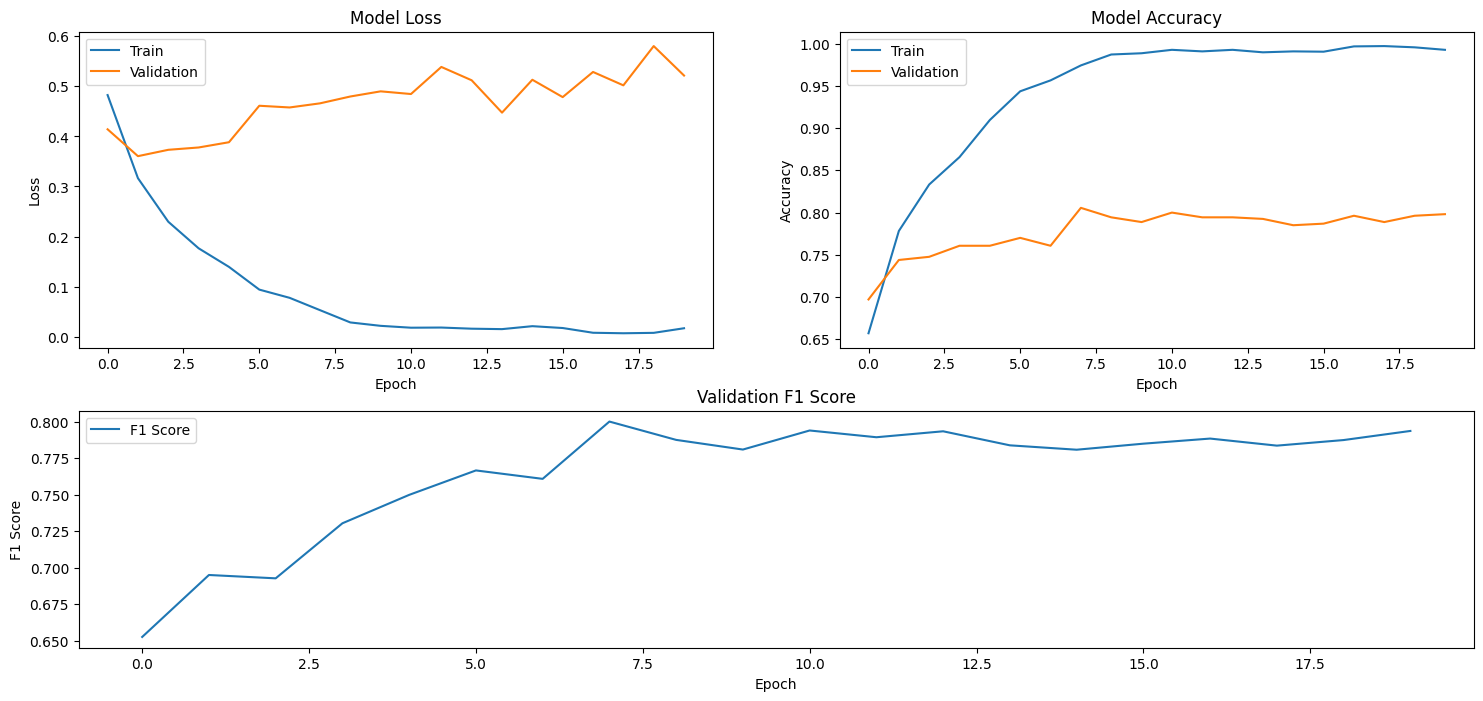

In [ ]:
plot_training_process(lstm_history, lstm_f1_scores)

In [ ]:
lstm_model, lstm_history, lstm_f1_scores = train_lstm_distilled(temperature=1.0, alpha=0.7)

accuracy,▁▃▅▅▆▇▇█████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
test_f1_score,▁
val_accuracy,▁▄▄▅▅▆▅█▇▇█▇▇▇▇▇▇▇▇█
val_f1_score,▁▃▃▅▆▆▆█▇▇█▇█▇▇▇▇▇▇█
val_loss,▃▁▁▂▂▄▄▄▅▅▅▇▆▄▆▅▆▆█▆
accuracy,0.99262
best_epoch,1
best_val_loss,0.36058
epoch,19


67/67 [==============================] - 1s 21ms/step
Epoch 1/20

Calculating validation F1 score...
17/17 [==============================] - 1s 5ms/step
Epoch: 1 - validation_data f1_score: 0.6212
85/85 - 15s - loss: 0.4824 - accuracy: 0.6601 - val_loss: 0.4178 - val_accuracy: 0.6822 - 15s/epoch - 182ms/step
Epoch 2/20

Calculating validation F1 score...
17/17 [==============================] - 0s 5ms/step
Epoch: 2 - validation_data f1_score: 0.6880
85/85 - 5s - loss: 0.3290 - accuracy: 0.7720 - val_loss: 0.3691 - val_accuracy: 0.7364 - 5s/epoch - 62ms/step
Epoch 3/20

Calculating validation F1 score...
17/17 [==============================] - 0s 5ms/step
Epoch: 3 - validation_data f1_score: 0.6923
85/85 - 3s - loss: 0.2386 - accuracy: 0.8321 - val_loss: 0.3733 - val_accuracy: 0.7439 - 3s/epoch - 33ms/step
Epoch 4/20

Calculating validation F1 score...
17/17 [==============================] - 0s 5ms/step
Epoch: 4 - validation_data f1_score: 0.7012
85/85 - 3s - loss: 0.1903 - accuracy:

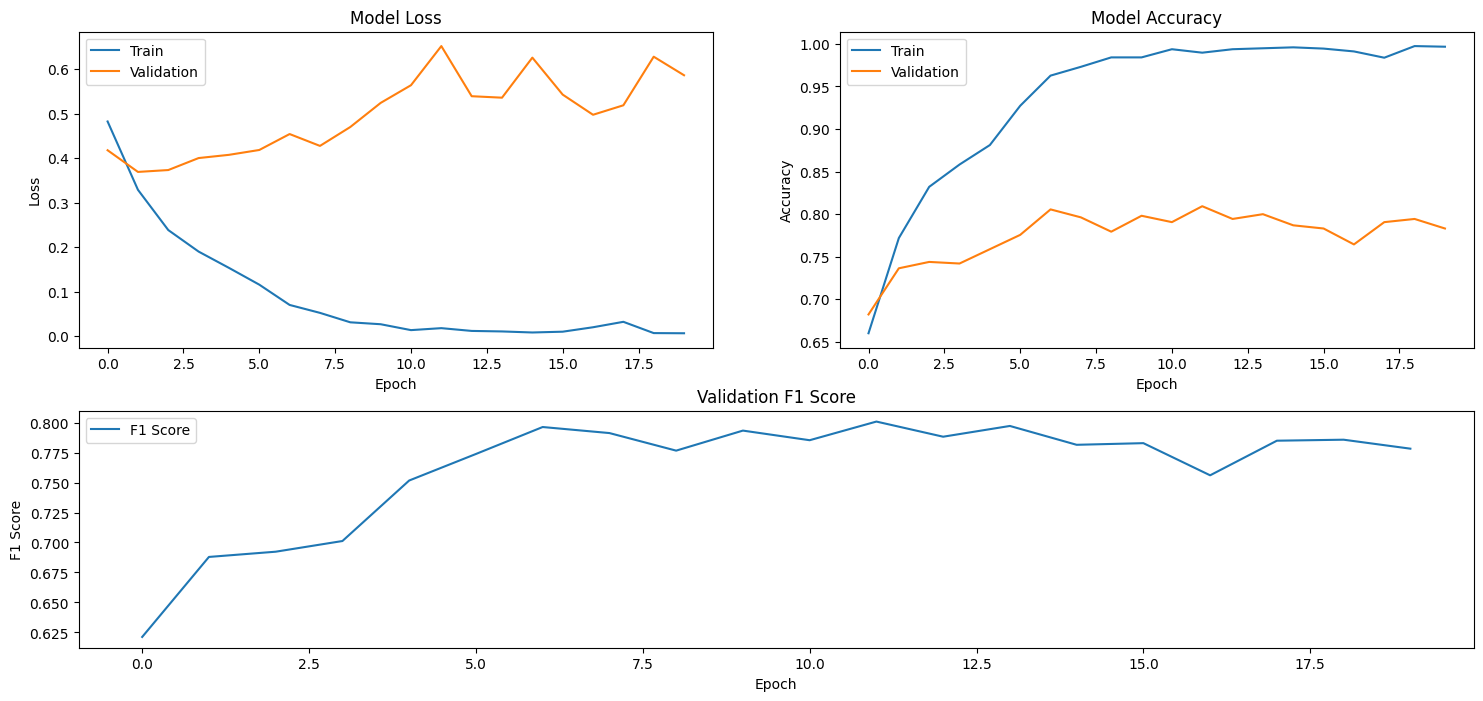

In [ ]:
plot_training_process(lstm_history, lstm_f1_scores)

In [ ]:
lstm_model, lstm_history, lstm_f1_scores = train_lstm_distilled(temperature=1.0, alpha=0.3)

accuracy,▁▃▅▅▆▇▇▇████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
test_f1_score,▁
val_accuracy,▁▄▄▄▅▆█▇▆▇▇█▇▇▇▇▆▇▇▇
val_f1_score,▁▄▄▄▆▇██▇█▇███▇▇▆▇▇▇
val_loss,▂▁▁▂▂▂▃▂▃▅▆█▅▅▇▅▄▅▇▆
accuracy,0.99668
best_epoch,1
best_val_loss,0.36912
epoch,19


67/67 [==============================] - 1s 20ms/step
Epoch 1/20

Calculating validation F1 score...
17/17 [==============================] - 1s 5ms/step
Epoch: 1 - validation_data f1_score: 0.6542
85/85 - 15s - loss: 0.4961 - accuracy: 0.6413 - val_loss: 0.4161 - val_accuracy: 0.7028 - 15s/epoch - 182ms/step
Epoch 2/20

Calculating validation F1 score...
17/17 [==============================] - 0s 5ms/step
Epoch: 2 - validation_data f1_score: 0.6552
85/85 - 6s - loss: 0.3342 - accuracy: 0.7594 - val_loss: 0.3946 - val_accuracy: 0.7159 - 6s/epoch - 66ms/step
Epoch 3/20

Calculating validation F1 score...
17/17 [==============================] - 0s 5ms/step
Epoch: 3 - validation_data f1_score: 0.7042
85/85 - 3s - loss: 0.2359 - accuracy: 0.8284 - val_loss: 0.3600 - val_accuracy: 0.7458 - 3s/epoch - 40ms/step
Epoch 4/20

Calculating validation F1 score...
17/17 [==============================] - 0s 5ms/step
Epoch: 4 - validation_data f1_score: 0.7185
85/85 - 3s - loss: 0.1863 - accuracy:

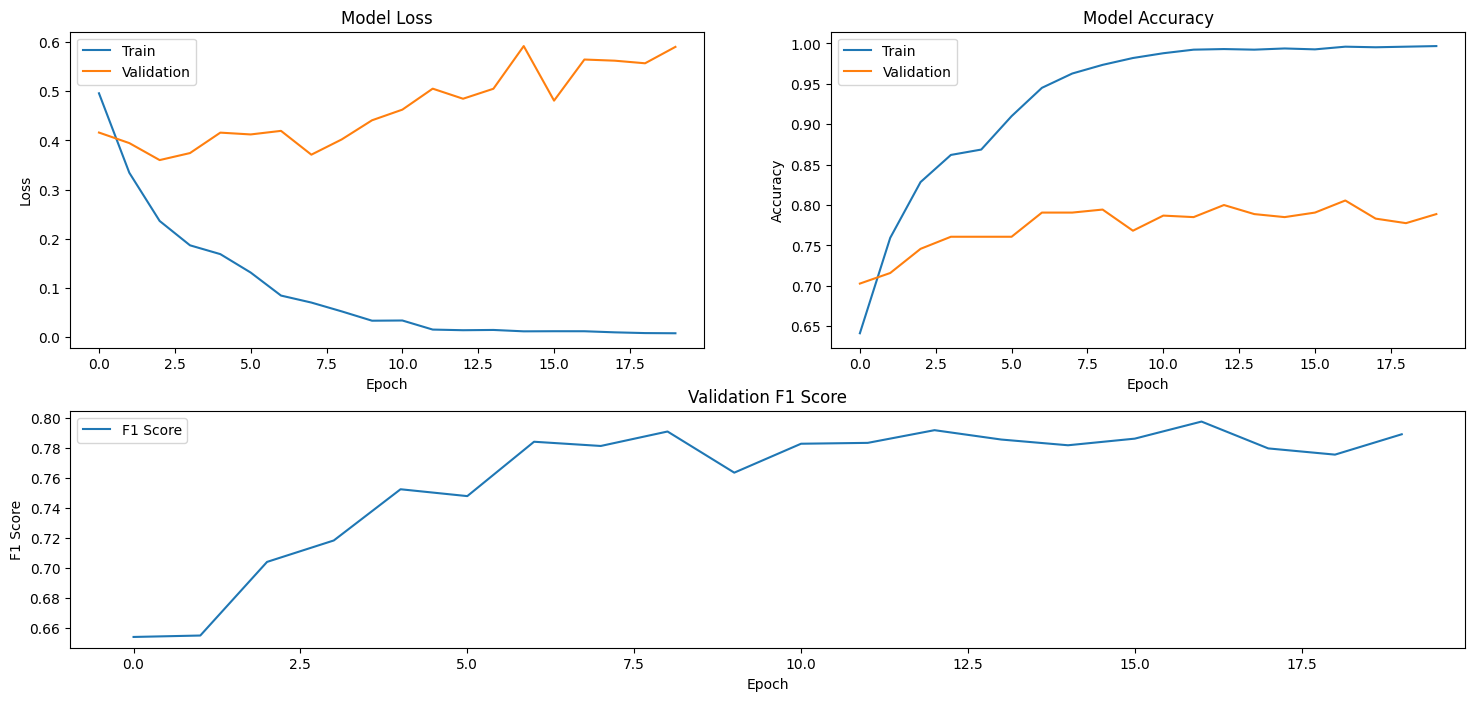

In [ ]:
plot_training_process(lstm_history, lstm_f1_scores)

In [ ]:
lstm_model, lstm_history, lstm_f1_scores = train_lstm_distilled(temperature=2.0, alpha=0.5)

accuracy,▁▃▅▅▅▆▇▇████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁
test_f1_score,▁
val_accuracy,▁▂▄▅▅▅▇▇▇▅▇▇█▇▇▇█▆▆▇
val_f1_score,▁▁▃▄▆▆▇▇█▆▇▇█▇▇▇█▇▇█
val_loss,▃▂▁▁▃▃▃▁▂▃▄▅▅▅█▅▇▇▇█
accuracy,0.99668
best_epoch,2
best_val_loss,0.36
epoch,19


67/67 [==============================] - 1s 22ms/step
Epoch 1/20

Calculating validation F1 score...
17/17 [==============================] - 1s 5ms/step
Epoch: 1 - validation_data f1_score: 0.6466
85/85 - 15s - loss: 0.4779 - accuracy: 0.6605 - val_loss: 0.4062 - val_accuracy: 0.6972 - 15s/epoch - 181ms/step
Epoch 2/20

Calculating validation F1 score...
17/17 [==============================] - 0s 6ms/step
Epoch: 2 - validation_data f1_score: 0.6845
85/85 - 6s - loss: 0.3156 - accuracy: 0.7808 - val_loss: 0.3806 - val_accuracy: 0.7364 - 6s/epoch - 74ms/step
Epoch 3/20

Calculating validation F1 score...
17/17 [==============================] - 0s 5ms/step
Epoch: 3 - validation_data f1_score: 0.6862
85/85 - 3s - loss: 0.2256 - accuracy: 0.8421 - val_loss: 0.4356 - val_accuracy: 0.7458 - 3s/epoch - 39ms/step
Epoch 4/20

Calculating validation F1 score...
17/17 [==============================] - 0s 5ms/step
Epoch: 4 - validation_data f1_score: 0.6915
85/85 - 3s - loss: 0.1932 - accuracy:

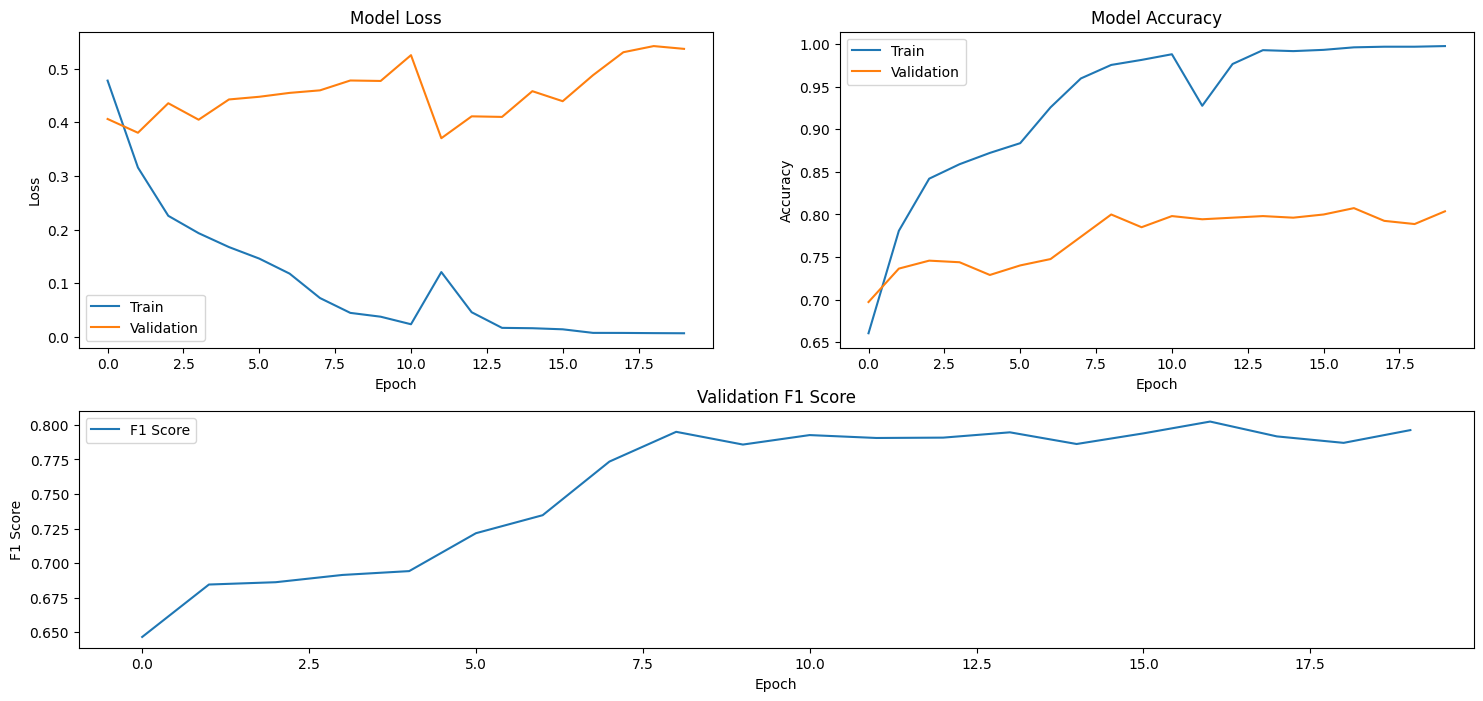

In [ ]:
plot_training_process(lstm_history, lstm_f1_scores)

In [ ]:
lstm_model, lstm_history, lstm_f1_scores = train_lstm_distilled(temperature=2.0, alpha=0.7)

accuracy,▁▃▅▅▅▆▇▇███▇████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▄▄▃▃▃▂▂▁▁▃▂▁▁▁▁▁▁▁
test_f1_score,▁
val_accuracy,▁▃▄▄▃▄▄▆█▇▇▇▇▇▇██▇▇█
val_f1_score,▁▃▃▃▃▄▅▇█▇█▇▇█▇███▇█
val_loss,▂▁▄▂▄▄▄▅▅▅▇▁▃▃▅▄▆███
accuracy,0.99779
best_epoch,11
best_val_loss,0.37036
epoch,19


67/67 [==============================] - 1s 20ms/step
Epoch 1/20

Calculating validation F1 score...
17/17 [==============================] - 1s 5ms/step
Epoch: 1 - validation_data f1_score: 0.6235
85/85 - 15s - loss: 0.4943 - accuracy: 0.6531 - val_loss: 0.4203 - val_accuracy: 0.6897 - 15s/epoch - 175ms/step
Epoch 2/20

Calculating validation F1 score...
17/17 [==============================] - 0s 5ms/step
Epoch: 2 - validation_data f1_score: 0.6886
85/85 - 6s - loss: 0.3229 - accuracy: 0.7705 - val_loss: 0.3606 - val_accuracy: 0.7346 - 6s/epoch - 71ms/step
Epoch 3/20

Calculating validation F1 score...
17/17 [==============================] - 0s 5ms/step
Epoch: 3 - validation_data f1_score: 0.6855
85/85 - 4s - loss: 0.2306 - accuracy: 0.8362 - val_loss: 0.3869 - val_accuracy: 0.7159 - 4s/epoch - 53ms/step
Epoch 4/20

Calculating validation F1 score...
17/17 [==============================] - 0s 4ms/step
Epoch: 4 - validation_data f1_score: 0.6937
85/85 - 3s - loss: 0.1955 - accuracy:

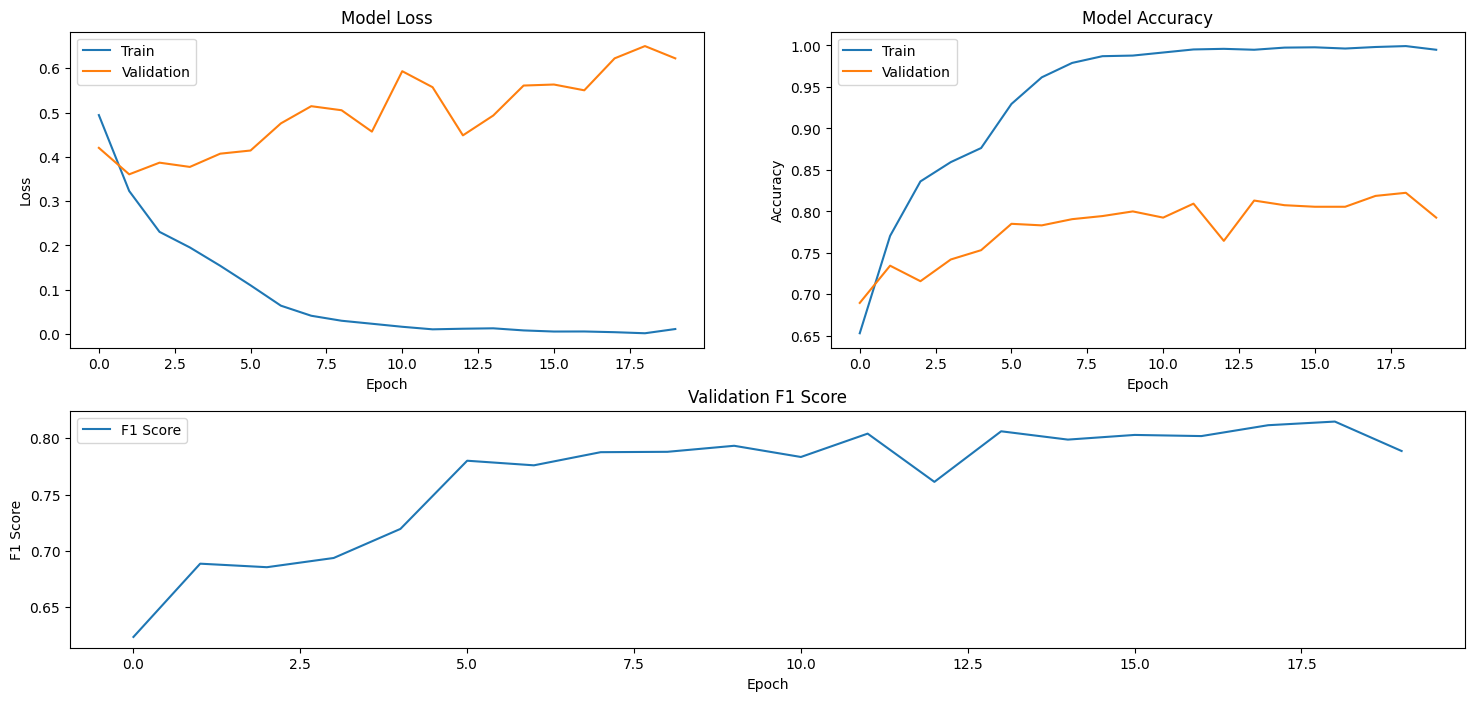

In [ ]:
plot_training_process(lstm_history, lstm_f1_scores)

In [ ]:
lstm_model, lstm_history, lstm_f1_scores = train_lstm_distilled(temperature=2.0, alpha=0.3)

accuracy,▁▃▅▅▆▇▇█████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
test_f1_score,▁
val_accuracy,▁▃▂▄▄▆▆▆▇▇▆▇▅█▇▇▇██▆
val_f1_score,▁▃▃▄▅▇▇▇▇▇▇█▆█▇████▇
val_loss,▂▁▂▁▂▂▄▅▄▃▇▆▃▄▆▆▆▇█▇
accuracy,0.99483
best_epoch,1
best_val_loss,0.36055
epoch,19


67/67 [==============================] - 1s 22ms/step
Epoch 1/20

Calculating validation F1 score...
17/17 [==============================] - 1s 6ms/step
Epoch: 1 - validation_data f1_score: 0.6282
85/85 - 15s - loss: 0.4853 - accuracy: 0.6576 - val_loss: 0.4194 - val_accuracy: 0.6916 - 15s/epoch - 175ms/step
Epoch 2/20

Calculating validation F1 score...
17/17 [==============================] - 0s 5ms/step
Epoch: 2 - validation_data f1_score: 0.6736
85/85 - 6s - loss: 0.3321 - accuracy: 0.7701 - val_loss: 0.3693 - val_accuracy: 0.7252 - 6s/epoch - 67ms/step
Epoch 3/20

Calculating validation F1 score...
17/17 [==============================] - 0s 5ms/step
Epoch: 3 - validation_data f1_score: 0.7030
85/85 - 3s - loss: 0.2255 - accuracy: 0.8384 - val_loss: 0.3820 - val_accuracy: 0.7458 - 3s/epoch - 35ms/step
Epoch 4/20

Calculating validation F1 score...
17/17 [==============================] - 0s 5ms/step
Epoch: 4 - validation_data f1_score: 0.6859
85/85 - 3s - loss: 0.1812 - accuracy:

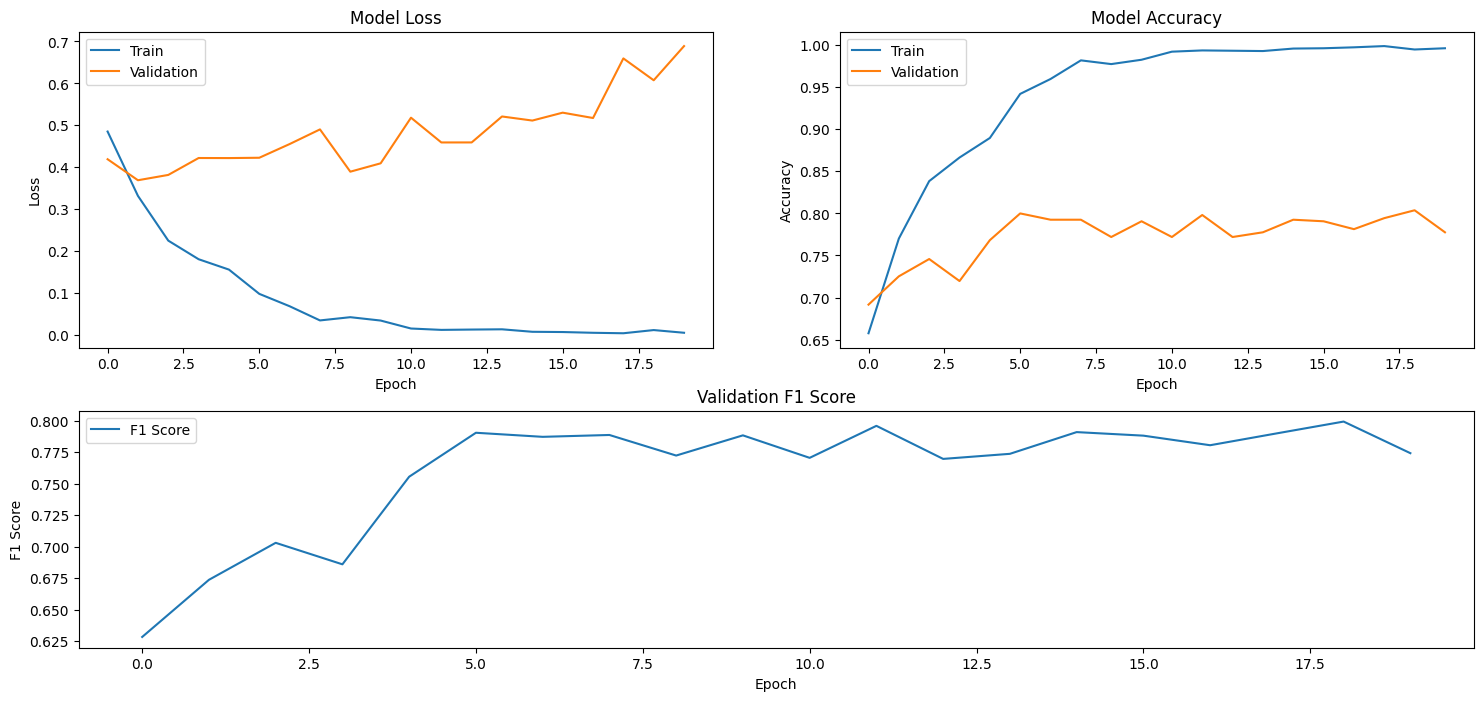

In [ ]:
plot_training_process(lstm_history, lstm_f1_scores)

In [ ]:
lstm_model, lstm_history, lstm_f1_scores = train_lstm_distilled(temperature=5.0, alpha=0.5)

accuracy,▁▃▅▅▆▇▇█████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▄▄▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
test_f1_score,▁
val_accuracy,▁▃▄▃▆█▇▇▆▇▆█▆▆▇▇▇▇█▆
val_f1_score,▁▃▄▃▆███▇█▇█▇▇██▇██▇
val_loss,▂▁▁▂▂▂▃▄▁▂▄▃▃▄▄▅▄▇▆█
accuracy,0.99631
best_epoch,1
best_val_loss,0.3693
epoch,19


67/67 [==============================] - 1s 22ms/step
Epoch 1/20

Calculating validation F1 score...
17/17 [==============================] - 1s 5ms/step
Epoch: 1 - validation_data f1_score: 0.6397
85/85 - 15s - loss: 0.4843 - accuracy: 0.6590 - val_loss: 0.4214 - val_accuracy: 0.6935 - 15s/epoch - 174ms/step
Epoch 2/20

Calculating validation F1 score...
17/17 [==============================] - 0s 5ms/step
Epoch: 2 - validation_data f1_score: 0.6491
85/85 - 6s - loss: 0.3239 - accuracy: 0.7764 - val_loss: 0.3896 - val_accuracy: 0.7121 - 6s/epoch - 69ms/step
Epoch 3/20

Calculating validation F1 score...
17/17 [==============================] - 0s 5ms/step
Epoch: 3 - validation_data f1_score: 0.7050
85/85 - 4s - loss: 0.2332 - accuracy: 0.8310 - val_loss: 0.3696 - val_accuracy: 0.7458 - 4s/epoch - 49ms/step
Epoch 4/20

Calculating validation F1 score...
17/17 [==============================] - 0s 5ms/step
Epoch: 4 - validation_data f1_score: 0.7327
85/85 - 3s - loss: 0.1881 - accuracy:

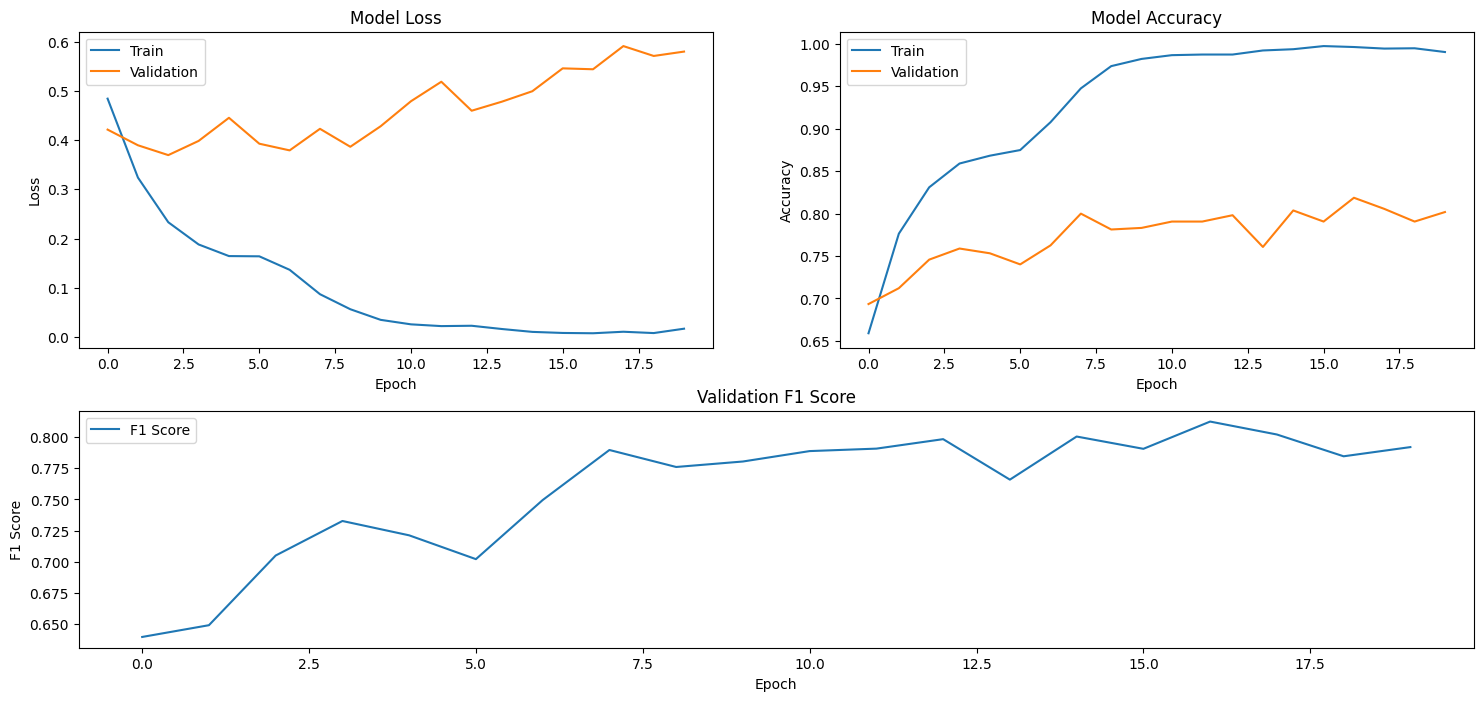

In [ ]:
plot_training_process(lstm_history, lstm_f1_scores)

In [ ]:
lstm_model, lstm_history, lstm_f1_scores = train_lstm_distilled(temperature=5.0, alpha=0.7)

accuracy,▁▃▅▅▅▅▆▇████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▄▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁
test_f1_score,▁
val_accuracy,▁▂▄▅▄▄▅▇▆▆▆▆▇▅▇▆█▇▆▇
val_f1_score,▁▁▄▅▄▄▅▇▇▇▇▇▇▆█▇██▇▇
val_loss,▃▂▁▂▃▂▁▃▂▃▄▆▄▄▅▇▇█▇█
accuracy,0.99041
best_epoch,2
best_val_loss,0.36958
epoch,19


67/67 [==============================] - 1s 22ms/step
Epoch 1/20

Calculating validation F1 score...
17/17 [==============================] - 1s 5ms/step
Epoch: 1 - validation_data f1_score: 0.6277
85/85 - 15s - loss: 0.4852 - accuracy: 0.6613 - val_loss: 0.4225 - val_accuracy: 0.6935 - 15s/epoch - 181ms/step
Epoch 2/20

Calculating validation F1 score...
17/17 [==============================] - 0s 5ms/step
Epoch: 2 - validation_data f1_score: 0.6749
85/85 - 5s - loss: 0.3271 - accuracy: 0.7672 - val_loss: 0.3823 - val_accuracy: 0.7271 - 5s/epoch - 60ms/step
Epoch 3/20

Calculating validation F1 score...
17/17 [==============================] - 0s 5ms/step
Epoch: 3 - validation_data f1_score: 0.7009
85/85 - 3s - loss: 0.2329 - accuracy: 0.8354 - val_loss: 0.3658 - val_accuracy: 0.7458 - 3s/epoch - 37ms/step
Epoch 4/20

Calculating validation F1 score...
17/17 [==============================] - 0s 5ms/step
Epoch: 4 - validation_data f1_score: 0.7329
85/85 - 3s - loss: 0.1770 - accuracy:

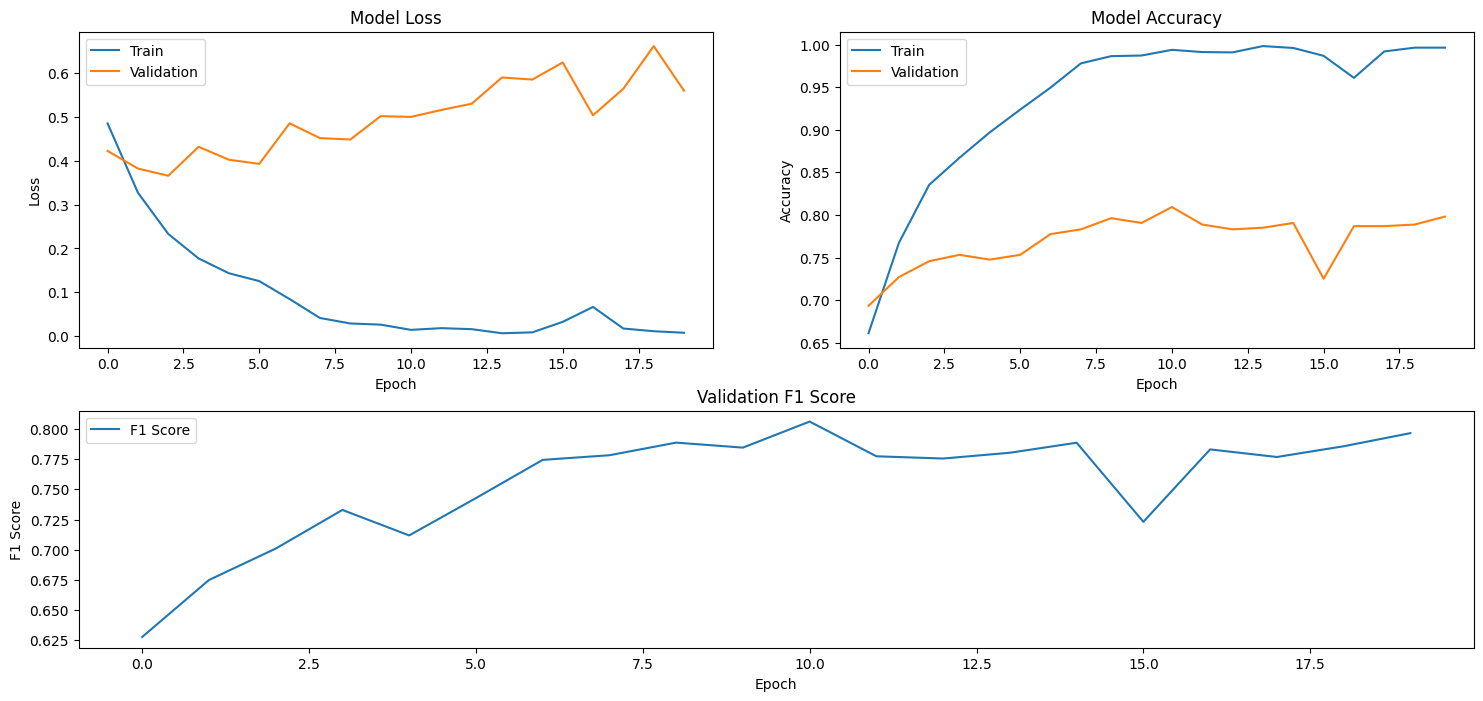

In [ ]:
plot_training_process(lstm_history, lstm_f1_scores)

In [ ]:
lstm_model, lstm_history, lstm_f1_scores = train_lstm_distilled(temperature=5.0, alpha=0.3)

accuracy,▁▃▅▅▆▆▇█████████▇███
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▄▃▃▃▂▂▁▁▁▁▁▁▁▁▂▁▁▁
test_f1_score,▁
val_accuracy,▁▃▄▅▄▅▆▆▇▇█▇▆▇▇▃▇▇▇▇
val_f1_score,▁▃▄▅▄▆▇▇▇▇█▇▇▇▇▅▇▇▇█
val_loss,▂▁▁▃▂▂▄▃▃▄▄▅▅▆▆▇▄▆█▆
accuracy,0.99631
best_epoch,2
best_val_loss,0.36583
epoch,19


67/67 [==============================] - 2s 23ms/step
Epoch 1/20

Calculating validation F1 score...
17/17 [==============================] - 1s 5ms/step
Epoch: 1 - validation_data f1_score: 0.6290
85/85 - 16s - loss: 0.4981 - accuracy: 0.6465 - val_loss: 0.4230 - val_accuracy: 0.6822 - 16s/epoch - 192ms/step
Epoch 2/20

Calculating validation F1 score...
17/17 [==============================] - 0s 4ms/step
Epoch: 2 - validation_data f1_score: 0.6830
85/85 - 4s - loss: 0.3248 - accuracy: 0.7782 - val_loss: 0.3656 - val_accuracy: 0.7271 - 4s/epoch - 44ms/step
Epoch 3/20

Calculating validation F1 score...
17/17 [==============================] - 0s 5ms/step
Epoch: 3 - validation_data f1_score: 0.6953
85/85 - 3s - loss: 0.2374 - accuracy: 0.8306 - val_loss: 0.3839 - val_accuracy: 0.7439 - 3s/epoch - 40ms/step
Epoch 4/20

Calculating validation F1 score...
17/17 [==============================] - 0s 5ms/step
Epoch: 4 - validation_data f1_score: 0.7210
85/85 - 4s - loss: 0.1887 - accuracy:

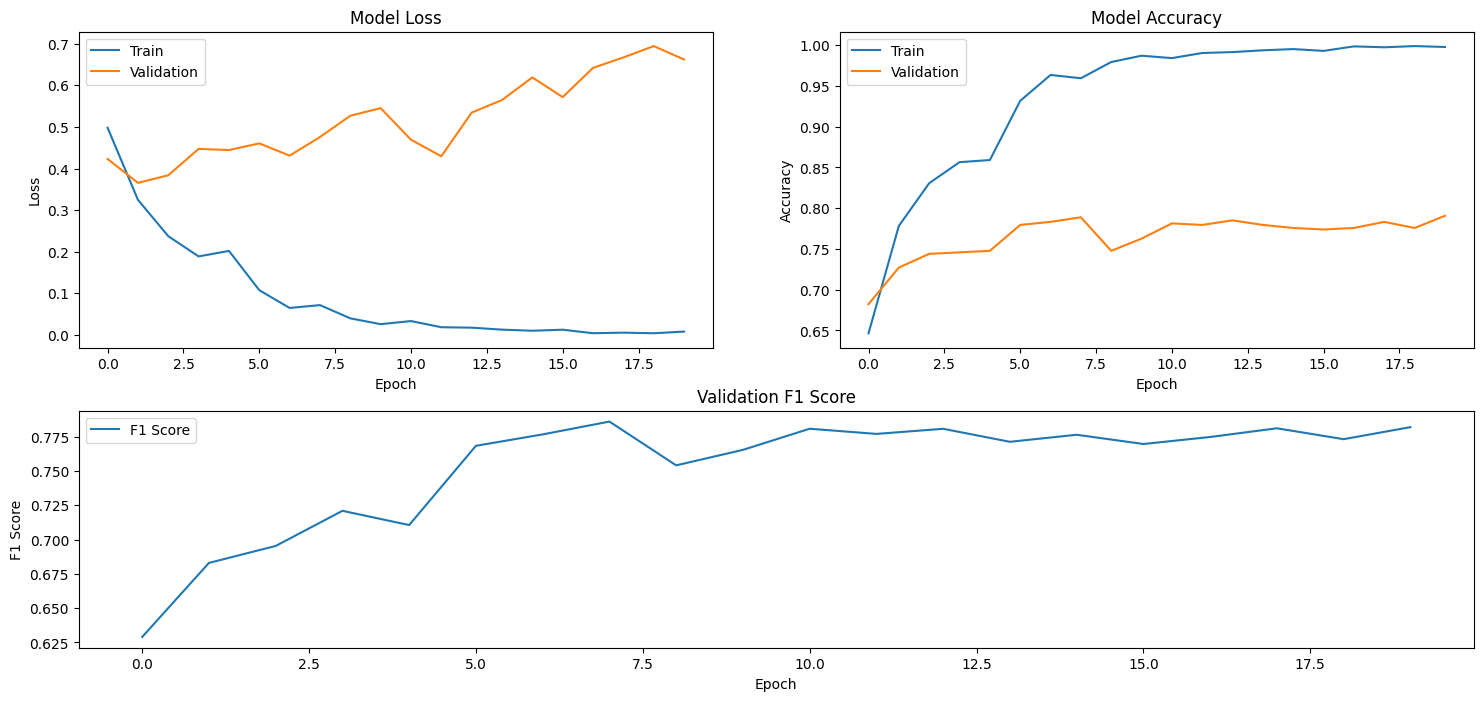

In [ ]:
plot_training_process(lstm_history, lstm_f1_scores)

# BERT

In [ ]:
distillbert_model, distillbert_history, distillbert_f1_scores = train_bert_distilled(temperature=1.0,
                                                                                     alpha=0.5)

accuracy,▁▄▅▅▅▇▇▇████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▄▄▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
test_f1_score,▁
val_accuracy,▁▄▅▅▅▇██▅▆▇▇█▇▇▇▇█▇█
val_f1_score,▁▃▄▅▅▇██▇▇███▇█▇▇█▇█
val_loss,▂▁▁▃▃▃▂▃▄▅▃▂▅▅▆▅▇▇█▇
accuracy,0.99779
best_epoch,1
best_val_loss,0.36558
epoch,19


67/67 [==============================] - 1s 20ms/step
Epoch 1/20
339/339 [==============================] - ETA: 0s - loss: 0.8156 - accuracy: 0.6509
Calculating validation F1 score...
Epoch: 1 - validation_data f1_score: 0.5817
339/339 [==============================] - 62s 114ms/step - loss: 0.8156 - accuracy: 0.6509 - val_loss: 0.6879 - val_accuracy: 0.6879
Epoch 2/20
339/339 [==============================] - ETA: 0s - loss: 0.6301 - accuracy: 0.7395
Calculating validation F1 score...
Epoch: 2 - validation_data f1_score: 0.6011
339/339 [==============================] - 16s 48ms/step - loss: 0.6301 - accuracy: 0.7395 - val_loss: 0.6642 - val_accuracy: 0.7103
Epoch 3/20
339/339 [==============================] - ETA: 0s - loss: 0.4854 - accuracy: 0.7982
Calculating validation F1 score...
Epoch: 3 - validation_data f1_score: 0.6255
339/339 [==============================] - 17s 50ms/step - loss: 0.4854 - accuracy: 0.7982 - val_loss: 0.7403 - val_accuracy: 0.7308
Epoch 4/20
339/339 [=

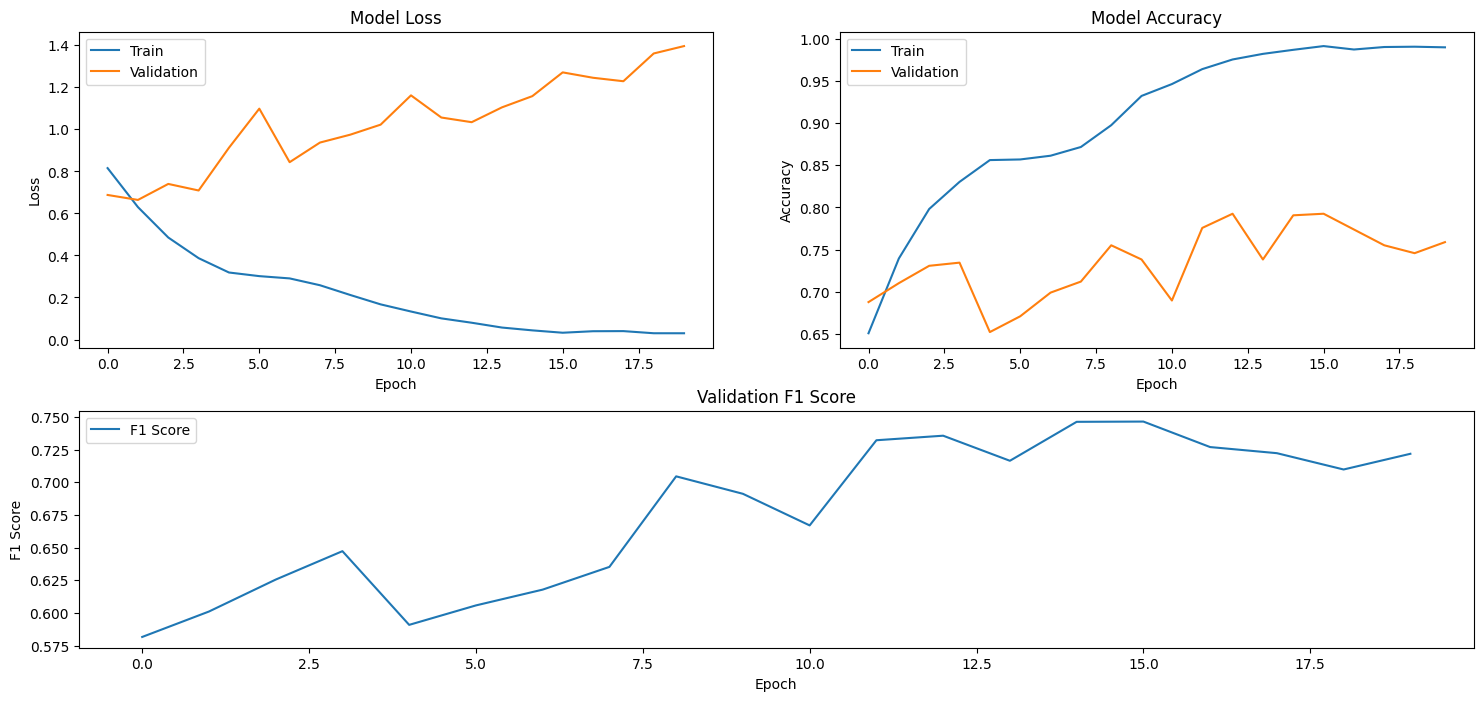

In [ ]:
plot_training_process(distillbert_history, distillbert_f1_scores)

In [ ]:
distillbert_model, distillbert_history, distillbert_f1_scores = train_bert_distilled(temperature=1.0,
                                                                                     alpha=0.8)

accuracy,▁▃▄▅▅▅▅▆▆▇▇▇████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁
test_f1_score,▁
val_accuracy,▃▄▅▅▁▂▃▄▆▅▃▇█▅██▇▆▆▆
val_f1_score,▁▂▃▄▁▂▃▃▆▆▅▇█▇██▇▇▆▇
val_loss,▁▁▂▁▃▅▃▄▄▄▆▅▅▅▆▇▇▆██
accuracy,0.98967
best_epoch,1
best_val_loss,0.66423
epoch,19


67/67 [==============================] - 1s 21ms/step
Epoch 1/20
339/339 [==============================] - ETA: 0s - loss: 0.8255 - accuracy: 0.6528
Calculating validation F1 score...
Epoch: 1 - validation_data f1_score: 0.5635
339/339 [==============================] - 57s 98ms/step - loss: 0.8255 - accuracy: 0.6528 - val_loss: 0.7087 - val_accuracy: 0.6804
Epoch 2/20
339/339 [==============================] - ETA: 0s - loss: 0.6255 - accuracy: 0.7402
Calculating validation F1 score...
Epoch: 2 - validation_data f1_score: 0.5941
339/339 [==============================] - 16s 49ms/step - loss: 0.6255 - accuracy: 0.7402 - val_loss: 0.7095 - val_accuracy: 0.7028
Epoch 3/20
339/339 [==============================] - ETA: 0s - loss: 0.4846 - accuracy: 0.7996
Calculating validation F1 score...
Epoch: 3 - validation_data f1_score: 0.6240
339/339 [==============================] - 16s 48ms/step - loss: 0.4846 - accuracy: 0.7996 - val_loss: 0.7105 - val_accuracy: 0.7308
Epoch 4/20
339/339 [==

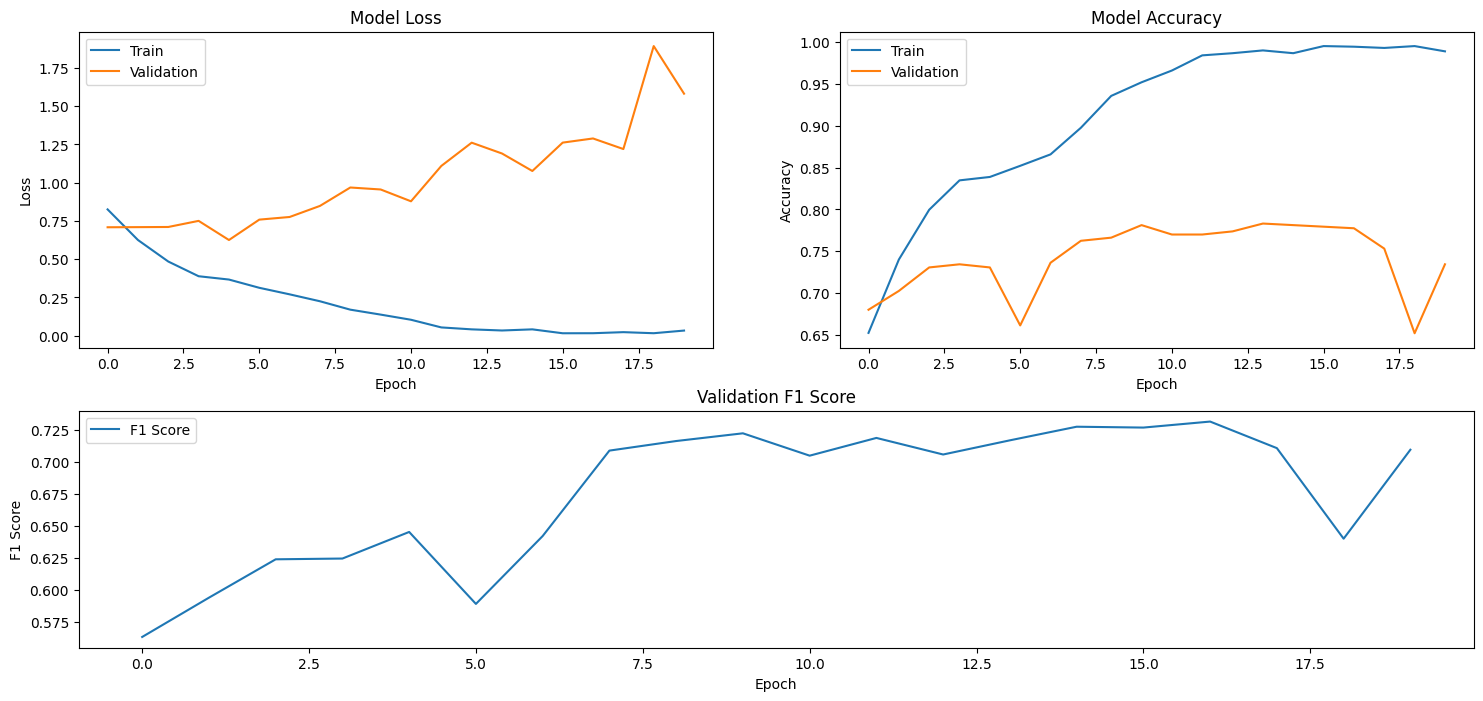

In [ ]:
plot_training_process(distillbert_history, distillbert_f1_scores)

accuracy,▁▃▄▅▅▅▅▆▇▇▇█████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁
test_f1_score,▁
val_accuracy,▂▄▅▅▅▁▅▇▇█▇▇█████▆▁▅
val_f1_score,▁▂▄▄▄▂▄▇▇█▇▇▇▇███▇▄▇
val_loss,▁▁▁▂▁▂▂▂▃▃▂▄▅▄▃▅▅▄█▆
accuracy,0.98856
best_epoch,4
best_val_loss,0.62533
epoch,19


67/67 [==============================] - 2s 23ms/step
Epoch 1/20
339/339 [==============================] - ETA: 0s - loss: 0.8172 - accuracy: 0.6528
Calculating validation F1 score...
Epoch: 1 - validation_data f1_score: 0.5920
339/339 [==============================] - 55s 97ms/step - loss: 0.8172 - accuracy: 0.6528 - val_loss: 0.6873 - val_accuracy: 0.6953
Epoch 2/20
339/339 [==============================] - ETA: 0s - loss: 0.6259 - accuracy: 0.7384
Calculating validation F1 score...
Epoch: 2 - validation_data f1_score: 0.6065
339/339 [==============================] - 17s 51ms/step - loss: 0.6259 - accuracy: 0.7384 - val_loss: 0.6609 - val_accuracy: 0.7084
Epoch 3/20
339/339 [==============================] - ETA: 0s - loss: 0.4823 - accuracy: 0.7959
Calculating validation F1 score...
Epoch: 3 - validation_data f1_score: 0.6241
339/339 [==============================] - 17s 49ms/step - loss: 0.4823 - accuracy: 0.7959 - val_loss: 0.8060 - val_accuracy: 0.7215
Epoch 4/20
339/339 [==

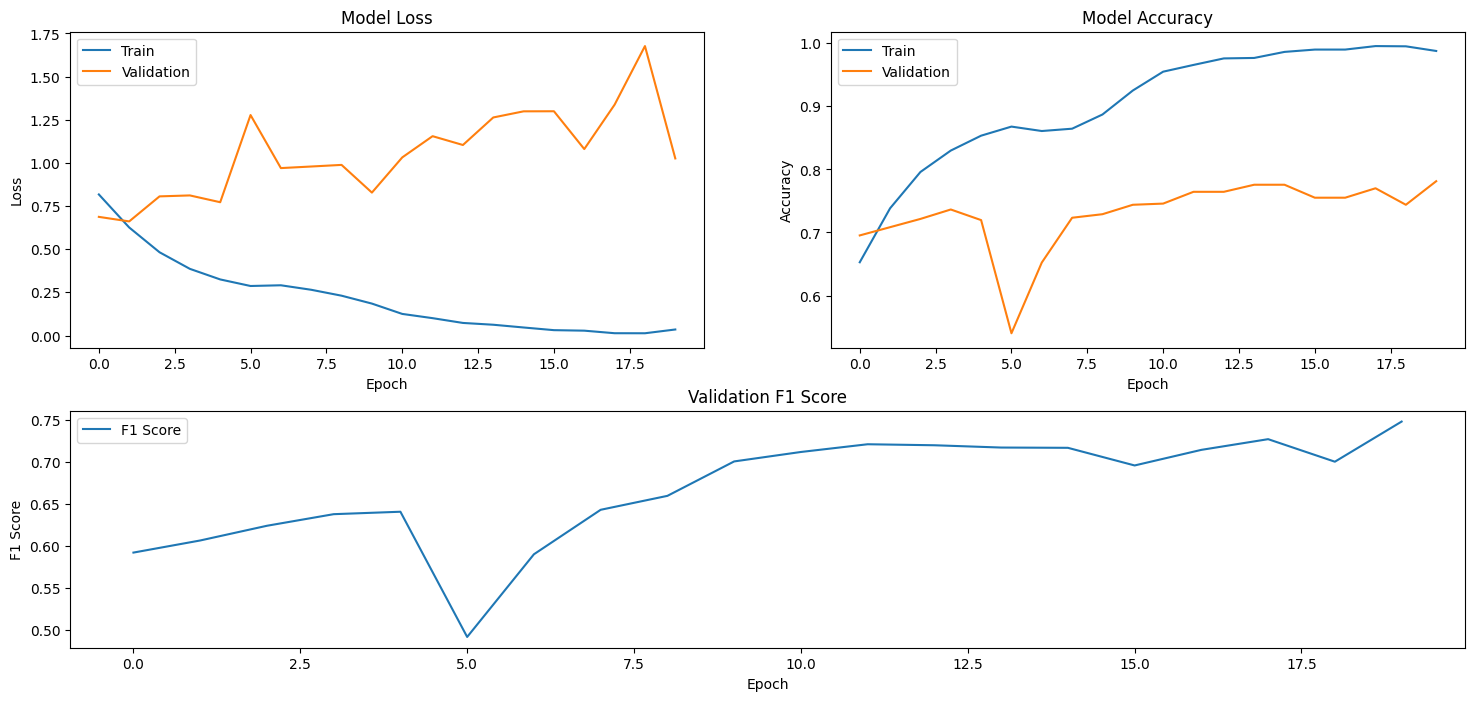

In [ ]:
distillbert_model, distillbert_history, distillbert_f1_scores = train_bert_distilled(temperature=1.0,
                                                                                     alpha=0.2)
plot_training_process(distillbert_history, distillbert_f1_scores)

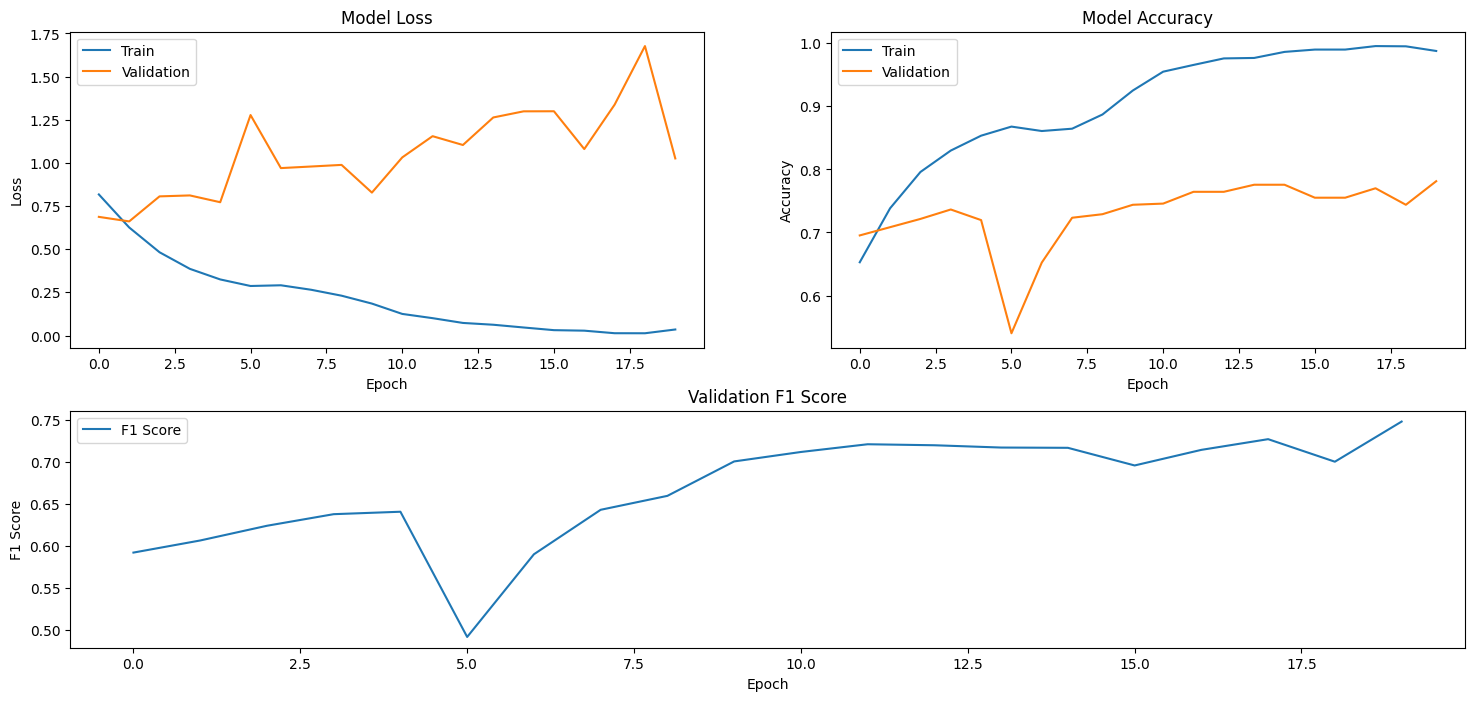

In [ ]:
plot_training_process(distillbert_history, distillbert_f1_scores)

In [ ]:
distillbert_model, distillbert_history, distillbert_f1_scores = train_bert_distilled(temperature=2.0,
                                                                                     alpha=0.5)

accuracy,▁▃▄▅▅▅▅▅▆▇▇▇████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
test_f1_score,▁
val_accuracy,▆▆▆▇▆▁▄▆▆▇▇████▇▇█▇█
val_f1_score,▄▄▅▅▅▁▄▅▆▇▇▇▇▇▇▇▇▇▇█
val_loss,▁▁▂▂▂▅▃▃▃▂▄▄▄▅▅▅▄▆█▄
accuracy,0.98782
best_epoch,1
best_val_loss,0.66094
epoch,19


67/67 [==============================] - 1s 20ms/step
Epoch 1/20
339/339 [==============================] - ETA: 0s - loss: 0.7744 - accuracy: 0.6542
Calculating validation F1 score...
Epoch: 1 - validation_data f1_score: 0.5788
339/339 [==============================] - 57s 98ms/step - loss: 0.7744 - accuracy: 0.6542 - val_loss: 0.6476 - val_accuracy: 0.6897
Epoch 2/20
339/339 [==============================] - ETA: 0s - loss: 0.5865 - accuracy: 0.7413
Calculating validation F1 score...
Epoch: 2 - validation_data f1_score: 0.5967
339/339 [==============================] - 17s 49ms/step - loss: 0.5865 - accuracy: 0.7413 - val_loss: 0.6697 - val_accuracy: 0.7065
Epoch 3/20
339/339 [==============================] - ETA: 0s - loss: 0.4677 - accuracy: 0.7941
Calculating validation F1 score...
Epoch: 3 - validation_data f1_score: 0.6109
339/339 [==============================] - 17s 49ms/step - loss: 0.4677 - accuracy: 0.7941 - val_loss: 0.7513 - val_accuracy: 0.7178
Epoch 4/20
339/339 [==

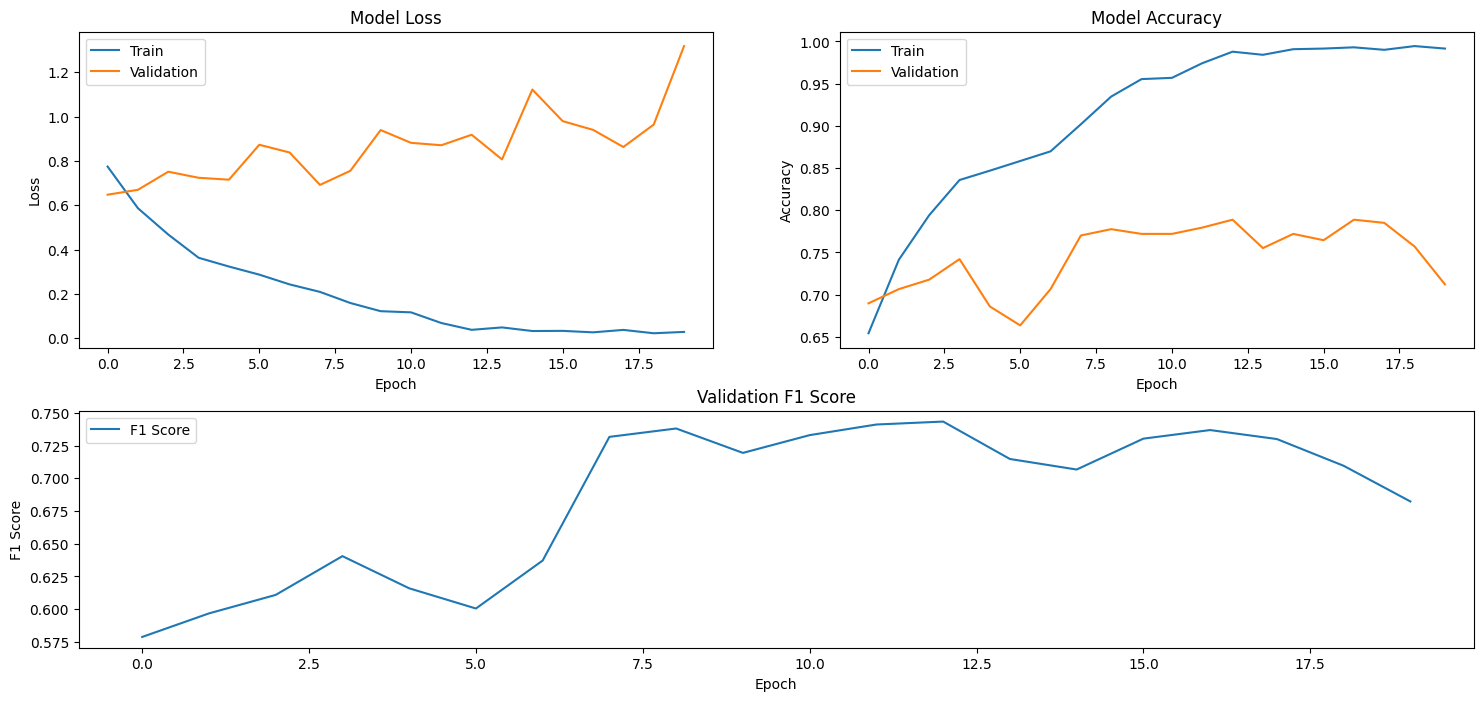

In [ ]:
plot_training_process(distillbert_history, distillbert_f1_scores)

In [ ]:
distillbert_model, distillbert_history, distillbert_f1_scores = train_bert_distilled(temperature=2.0,
                                                                                     alpha=0.8)

accuracy,▁▃▄▅▅▅▅▆▇▇▇█████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁
test_f1_score,▁
val_accuracy,▂▃▄▅▂▁▃▇▇▇▇▇█▆▇▇██▆▄
val_f1_score,▁▂▂▄▃▂▃██▇███▇▆▇█▇▇▅
val_loss,▁▁▂▂▂▃▃▁▂▄▃▃▄▃▆▄▄▃▄█
accuracy,0.99151
best_epoch,0
best_val_loss,0.64755
epoch,19


67/67 [==============================] - 1s 21ms/step
Epoch 1/20
339/339 [==============================] - ETA: 0s - loss: 0.7859 - accuracy: 0.6520
Calculating validation F1 score...
Epoch: 1 - validation_data f1_score: 0.5789
339/339 [==============================] - 56s 98ms/step - loss: 0.7859 - accuracy: 0.6520 - val_loss: 0.6614 - val_accuracy: 0.6879
Epoch 2/20
339/339 [==============================] - ETA: 0s - loss: 0.5903 - accuracy: 0.7402
Calculating validation F1 score...
Epoch: 2 - validation_data f1_score: 0.6025
339/339 [==============================] - 16s 49ms/step - loss: 0.5903 - accuracy: 0.7402 - val_loss: 0.6210 - val_accuracy: 0.7140
Epoch 3/20
339/339 [==============================] - ETA: 0s - loss: 0.4635 - accuracy: 0.7974
Calculating validation F1 score...
Epoch: 3 - validation_data f1_score: 0.6139
339/339 [==============================] - 17s 49ms/step - loss: 0.4635 - accuracy: 0.7974 - val_loss: 0.7648 - val_accuracy: 0.7234
Epoch 4/20
339/339 [==

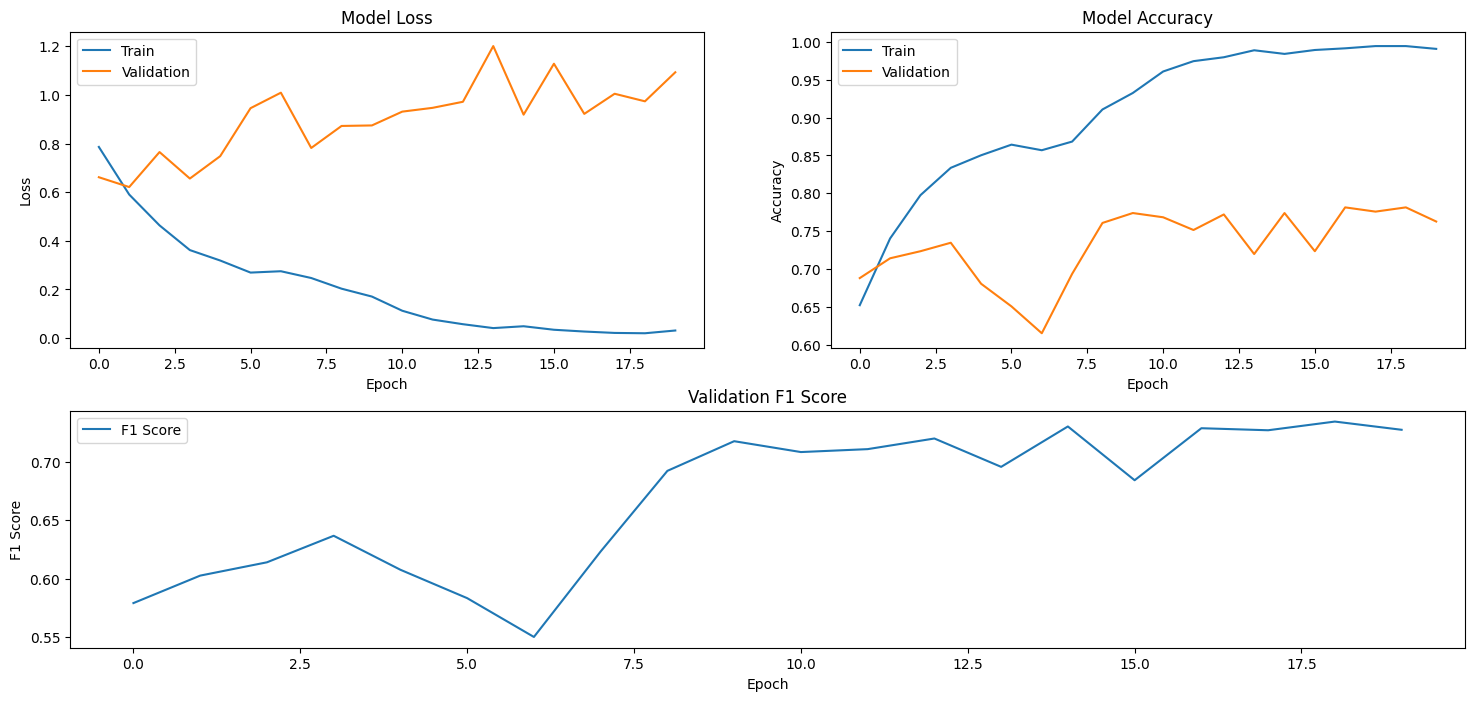

In [ ]:
plot_training_process(distillbert_history, distillbert_f1_scores)

In [ ]:
distillbert_model, distillbert_history, distillbert_f1_scores = train_bert_distilled(temperature=2.0,
                                                                                     alpha=0.2)

accuracy,▁▃▄▅▅▅▅▅▆▇▇█████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁
test_f1_score,▁
val_accuracy,▄▅▆▆▄▂▁▄▇█▇▇█▅█▆███▇
val_f1_score,▂▃▃▄▃▂▁▄▆▇▇▇▇▇█▆████
val_loss,▁▁▃▁▃▅▆▃▄▄▅▅▅█▅▇▅▆▅▇
accuracy,0.99077
best_epoch,1
best_val_loss,0.62099
epoch,19


67/67 [==============================] - 2s 23ms/step
Epoch 1/20
339/339 [==============================] - ETA: 0s - loss: 0.7792 - accuracy: 0.6487
Calculating validation F1 score...
Epoch: 1 - validation_data f1_score: 0.5906
339/339 [==============================] - 60s 100ms/step - loss: 0.7792 - accuracy: 0.6487 - val_loss: 0.6429 - val_accuracy: 0.6972
Epoch 2/20
339/339 [==============================] - ETA: 0s - loss: 0.5960 - accuracy: 0.7384
Calculating validation F1 score...
Epoch: 2 - validation_data f1_score: 0.5990
339/339 [==============================] - 17s 49ms/step - loss: 0.5960 - accuracy: 0.7384 - val_loss: 0.6606 - val_accuracy: 0.7103
Epoch 3/20
339/339 [==============================] - ETA: 0s - loss: 0.4581 - accuracy: 0.7956
Calculating validation F1 score...
Epoch: 3 - validation_data f1_score: 0.6260
339/339 [==============================] - 17s 49ms/step - loss: 0.4581 - accuracy: 0.7956 - val_loss: 0.7030 - val_accuracy: 0.7290
Epoch 4/20
339/339 [=

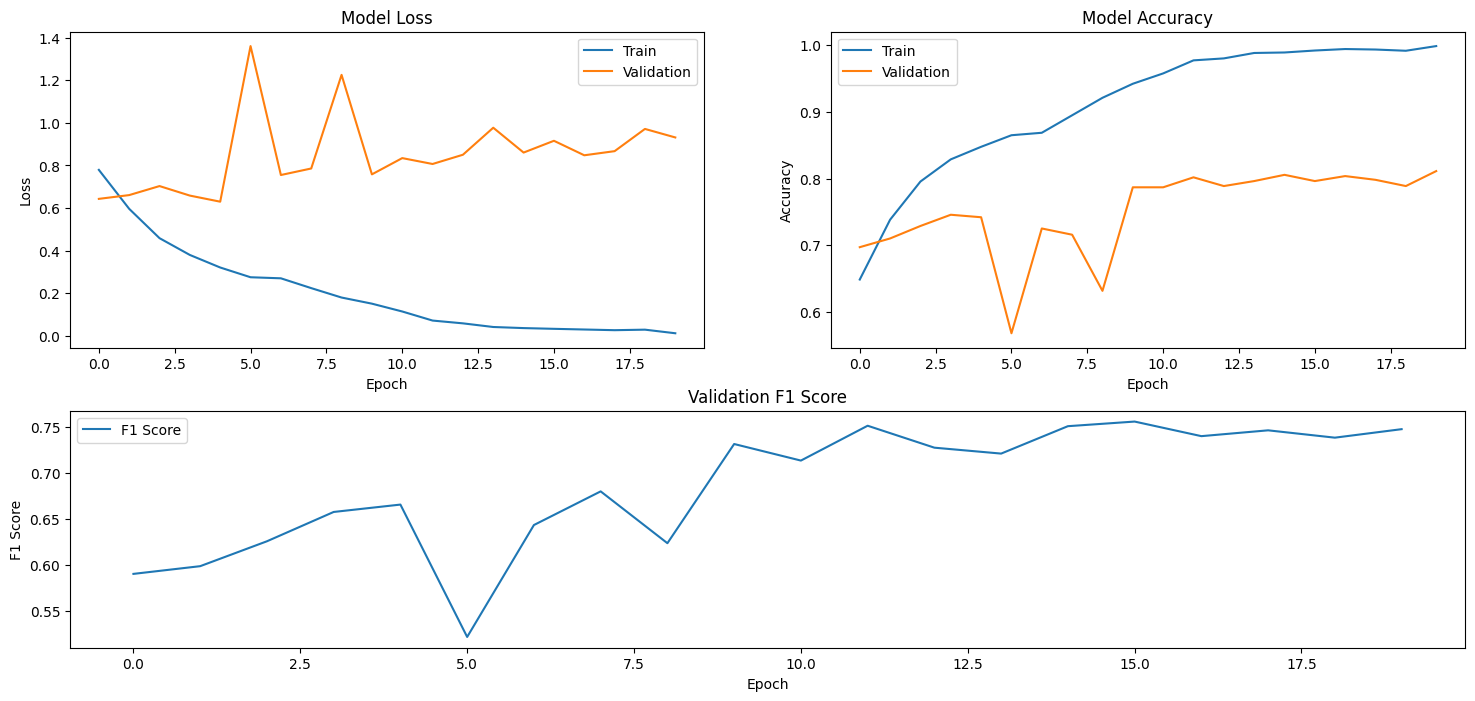

In [ ]:
plot_training_process(distillbert_history, distillbert_f1_scores)

In [ ]:
distillbert_model, distillbert_history, distillbert_f1_scores = train_bert_distilled(temperature=3.0,
                                                                                     alpha=0.5)

accuracy,▁▃▄▅▅▅▅▆▆▇▇█████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁
test_f1_score,▁
val_accuracy,▅▅▆▆▆▁▆▅▃▇▇█▇█████▇█
val_f1_score,▃▃▄▅▅▁▅▆▄▇▇█▇▇████▇█
val_loss,▁▁▂▁▁█▂▂▇▂▃▃▃▄▃▄▃▃▄▄
accuracy,0.99852
best_epoch,4
best_val_loss,0.62962
epoch,19


67/67 [==============================] - 1s 20ms/step
Epoch 1/20
339/339 [==============================] - ETA: 0s - loss: 0.6963 - accuracy: 0.6491
Calculating validation F1 score...
Epoch: 1 - validation_data f1_score: 0.5748
339/339 [==============================] - 57s 98ms/step - loss: 0.6963 - accuracy: 0.6491 - val_loss: 0.6046 - val_accuracy: 0.6841
Epoch 2/20
339/339 [==============================] - ETA: 0s - loss: 0.5343 - accuracy: 0.7421
Calculating validation F1 score...
Epoch: 2 - validation_data f1_score: 0.5985
339/339 [==============================] - 17s 49ms/step - loss: 0.5343 - accuracy: 0.7421 - val_loss: 0.5608 - val_accuracy: 0.7121
Epoch 3/20
339/339 [==============================] - ETA: 0s - loss: 0.4266 - accuracy: 0.7882
Calculating validation F1 score...
Epoch: 3 - validation_data f1_score: 0.6053
339/339 [==============================] - 16s 49ms/step - loss: 0.4266 - accuracy: 0.7882 - val_loss: 0.6613 - val_accuracy: 0.7178
Epoch 4/20
339/339 [==

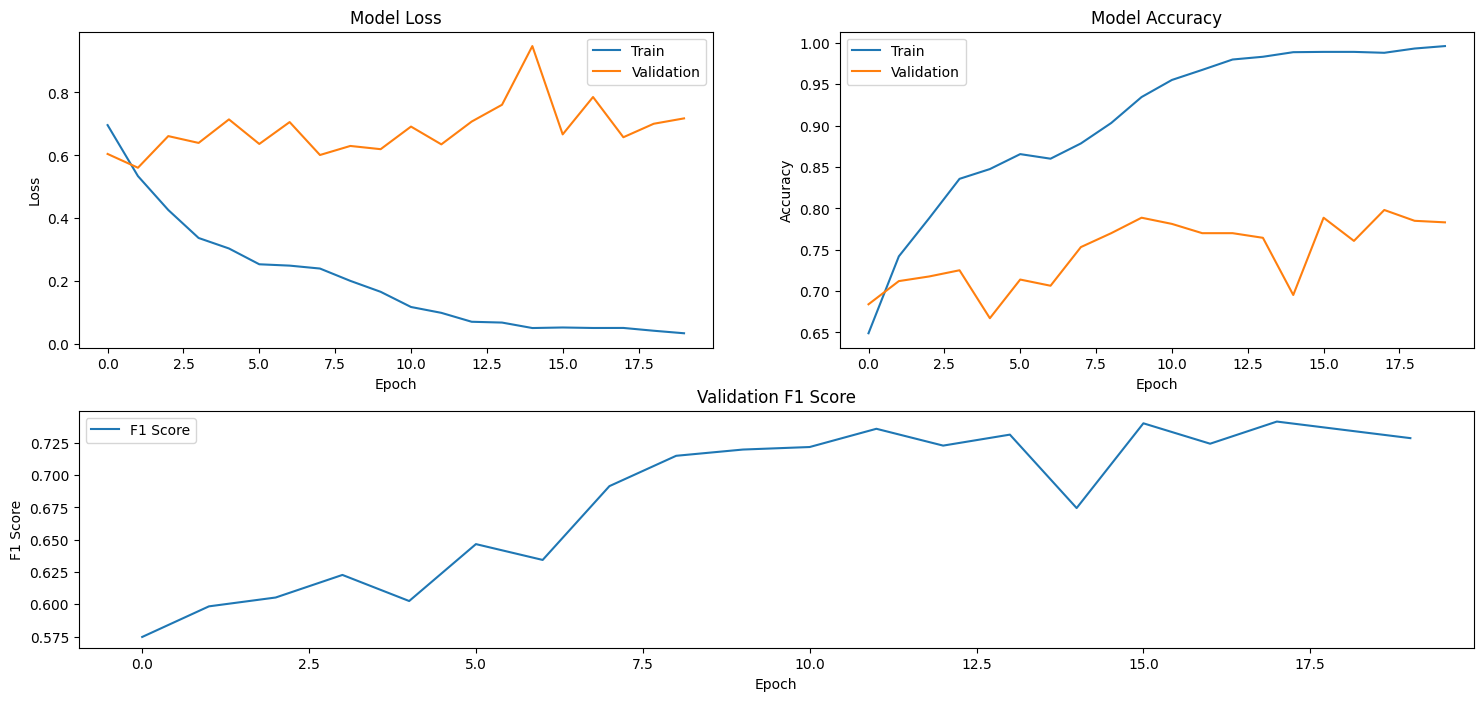

In [ ]:
plot_training_process(distillbert_history, distillbert_f1_scores)

In [ ]:
distillbert_model, distillbert_history, distillbert_f1_scores = train_bert_distilled(temperature=3.0,
                                                                                     alpha=0.8)

accuracy,▁▃▄▅▅▅▅▆▆▇▇▇████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁
test_f1_score,▁
val_accuracy,▂▃▄▄▁▃▃▆▆▇▇▆▆▆▂▇▆█▇▇
val_f1_score,▁▂▂▃▂▄▄▆▇▇▇█▇█▅█▇██▇
val_loss,▂▁▃▂▄▂▄▂▂▂▃▂▄▅█▃▅▃▄▄
accuracy,0.99631
best_epoch,1
best_val_loss,0.56079
epoch,19


67/67 [==============================] - 2s 24ms/step
Epoch 1/20
339/339 [==============================] - ETA: 0s - loss: 0.6988 - accuracy: 0.6517
Calculating validation F1 score...
Epoch: 1 - validation_data f1_score: 0.5599
339/339 [==============================] - 57s 102ms/step - loss: 0.6988 - accuracy: 0.6517 - val_loss: 0.6182 - val_accuracy: 0.6766
Epoch 2/20
339/339 [==============================] - ETA: 0s - loss: 0.5391 - accuracy: 0.7380
Calculating validation F1 score...
Epoch: 2 - validation_data f1_score: 0.5785
339/339 [==============================] - 17s 51ms/step - loss: 0.5391 - accuracy: 0.7380 - val_loss: 0.6279 - val_accuracy: 0.6916
Epoch 3/20
339/339 [==============================] - ETA: 0s - loss: 0.4194 - accuracy: 0.7989
Calculating validation F1 score...
Epoch: 3 - validation_data f1_score: 0.6178
339/339 [==============================] - 17s 50ms/step - loss: 0.4194 - accuracy: 0.7989 - val_loss: 0.6038 - val_accuracy: 0.7271
Epoch 4/20
339/339 [=

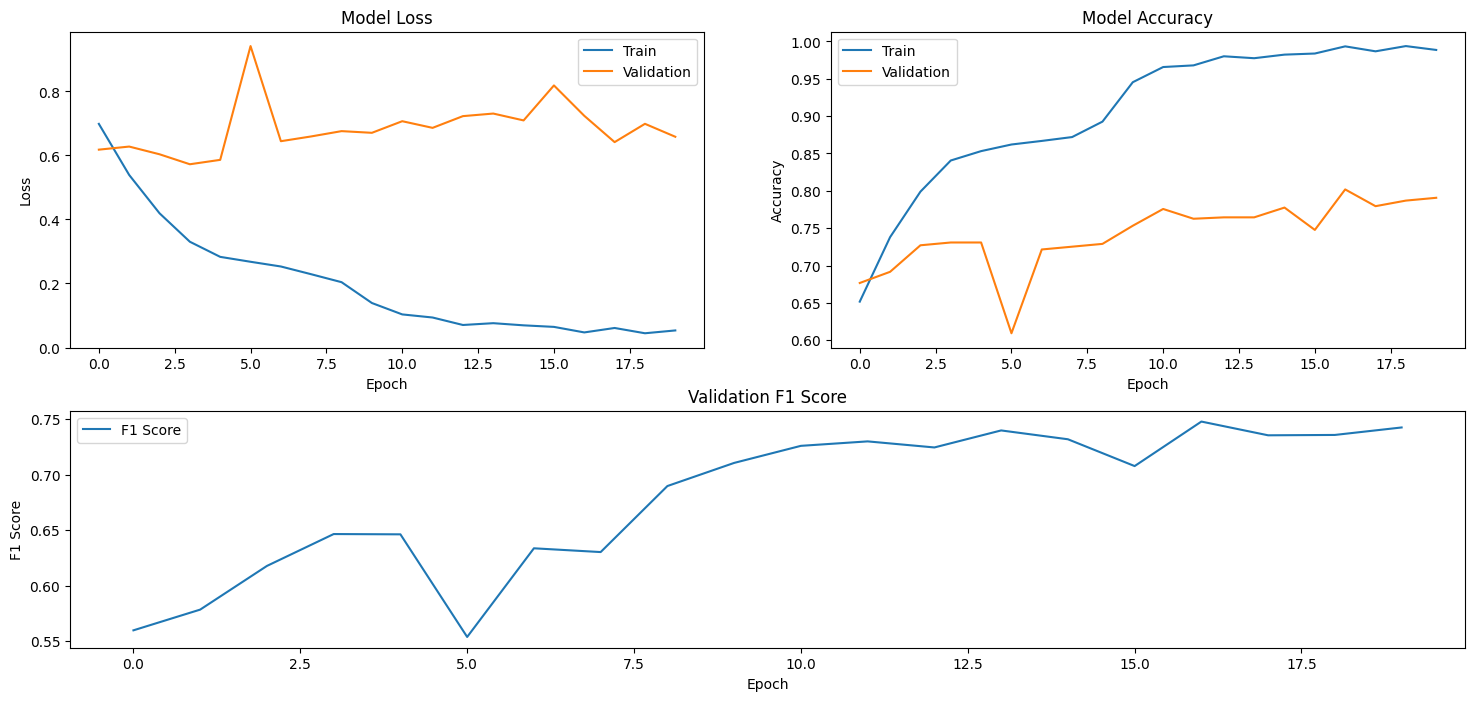

In [ ]:
plot_training_process(distillbert_history, distillbert_f1_scores)

In [ ]:
distillbert_model, distillbert_history, distillbert_f1_scores = train_bert_distilled(temperature=3.0,
                                                                                     alpha=0.2)

wandb: Currently logged in as: iankelk. Use `wandb login --relogin` to force relogin


67/67 [==============================] - 5s 24ms/step
Epoch 1/20
339/339 [==============================] - ETA: 0s - loss: 0.6915 - accuracy: 0.6542
Calculating validation F1 score...
Epoch: 1 - validation_data f1_score: 0.5847
339/339 [==============================] - 64s 115ms/step - loss: 0.6915 - accuracy: 0.6542 - val_loss: 0.5709 - val_accuracy: 0.6897
Epoch 2/20
339/339 [==============================] - ETA: 0s - loss: 0.5253 - accuracy: 0.7443
Calculating validation F1 score...
Epoch: 2 - validation_data f1_score: 0.6127
339/339 [==============================] - 16s 48ms/step - loss: 0.5253 - accuracy: 0.7443 - val_loss: 0.5403 - val_accuracy: 0.7178
Epoch 3/20
339/339 [==============================] - ETA: 0s - loss: 0.4167 - accuracy: 0.8022
Calculating validation F1 score...
Epoch: 3 - validation_data f1_score: 0.6388
339/339 [==============================] - 16s 48ms/step - loss: 0.4167 - accuracy: 0.8022 - val_loss: 0.5444 - val_accuracy: 0.7346
Epoch 4/20
339/339 [=

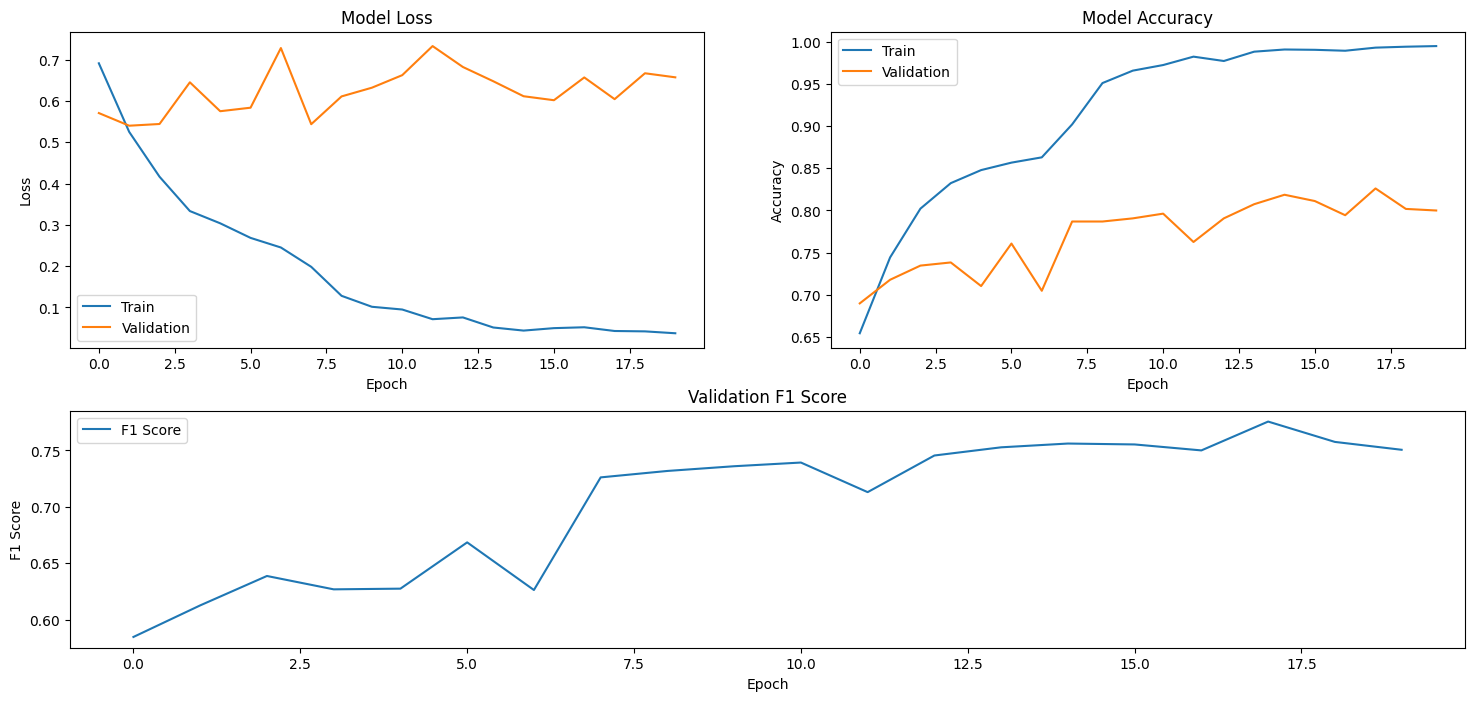

In [ ]:
plot_training_process(distillbert_history, distillbert_f1_scores)

# Disconnect from Colab

Since I'm runnning using an upgraded GPU, this disconnects immediately from Colab to stop the usage timer so that I don't continue to use my GPU credits.



In [ ]:
# from google.colab import runtime
# runtime.unassign()